In [1]:
import os
import cv2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import pickle

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall, FalseNegatives, FalsePositives, TruePositives, TrueNegatives

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [2]:
os.environ['KAGGLE_USERNAME'] = "lorddexter"
os.environ['KAGGLE_KEY'] = "bf0fec1866a689351f73244d4dd09a99"
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 99% 666M/675M [00:05<00:00, 170MB/s]
100% 675M/675M [00:05<00:00, 125MB/s]


In [3]:
!unzip cell-images-for-detecting-malaria.zip

Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_i

In [4]:
base_path = '/content/cell_images/cell_images'

In [5]:
def load_and_preprocess_images(base_path):

  Image_files = []
  Labels = []
  Dataset = []
  
  for label in os.listdir(base_path):

    # append labels from sub-directory names
    Labels.append(label)
    
    # creating image path
    images_path = os.path.join(base_path, label)
    
    for image_name in os.listdir(images_path):

      image_paths = os.path.join(images_path, image_name)
      
      # read the images
      img = cv2.imread(image_paths)

      try:
        
        # resizing the images
        img = cv2.resize(img, (75, 75), cv2.INTER_CUBIC)

        # make copy of resized image for edge detection
        img_copy = img.copy()
    
        # convert the images to grayscale for edge detection
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)   
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2GRAY)

        # preprocessing using canny edge detector to make image edges sharper and image smoother
        img_copy = cv2.GaussianBlur(img, (7,7), 0) 
        edges = cv2.Canny(img_copy, threshold1 = 80, threshold2 = 160)
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
        
        # superimposing image with detected edges
        final_img = cv2.addWeighted(img, 0.5, edges, 0.5, 0)
        
        Dataset.append([final_img, np.array(label)])
      except:
        continue

  return Dataset

In [6]:
Dataset = load_and_preprocess_images(base_path)

In [7]:
Data = pd.DataFrame(Dataset, columns = ['Images', 'Labels'])

In [8]:
Data.head()

Images      Labels
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  Uninfected
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  Uninfected
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  Uninfected
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  Uninfected
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  Uninfected

In [9]:
def Labels_to_numeric(x):
        if x == 'Parasitized':
          return 1
        if x == 'Uninfected':
          return 0

Data['Labels'] = Data['Labels'].apply(Labels_to_numeric)
print(Data.head())

                                              Images  Labels
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
2  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0


In [10]:
x = np.array([i for i in Data['Images']]).reshape(-1, 75, 75, 3)
y = to_categorical([i for i in Data['Labels']])

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, shuffle = True, random_state = 2)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(22046, 75, 75, 3)
(5512, 75, 75, 3)
(22046, 2)
(5512, 2)


In [13]:
X_train = X_train/255.
X_val = X_val/255.

In [14]:
# defining evaluation metrics

precision = Precision()
recall = Recall()
false_positive = FalsePositives()
false_negative = FalseNegatives()
true_positive = TruePositives()
true_negative = TrueNegatives()

In [15]:
class myCallback(tensorflow.keras.callbacks.Callback):

  def on_epoch_end(self, epochs, logs = {}):
    if (logs.get('accuracy') > 0.98):
      self.model.stop_training = True

myCallback = myCallback()

mobilenet_rlop = ReduceLROnPlateau(monitor = 'accuracy', patience = 5)

In [16]:
inception_resnet = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = (75, 75, 3))
inception_resnet.trainable = False

219070464/219055592 [==============================] - 2s 0us/step


In [17]:
x = Flatten()(inception_resnet.output)
dense1 = Dense(units = 504, activation = 'relu')(x)
dense2 = Dense(units=128,activation='relu')(dense1)
output = Dense(units=2, activation='sigmoid')(dense2)
inception_resnet_model = Model(inputs = inception_resnet.input, outputs = output)

In [18]:
inception_resnet_adam = Adam(learning_rate = 0.0001)
inception_resnet_sgd = SGD(learning_rate = 0.00001, momentum = 0.8, nesterov = True)

inception_resnet_model.compile(optimizer = inception_resnet_sgd, loss = 'binary_crossentropy', metrics = ['accuracy', precision, recall, true_positive, true_negative, false_positive,])

In [19]:
inception_resnet_model.fit(x = X_train, y = Y_train, validation_data = [X_val, Y_val], epochs = 15, callbacks = [myCallback])

Epoch 1/15
689/689 [==============================] - 124s 144ms/step - loss: 0.7118 - accuracy: 0.6140 - precision: 0.5919 - recall: 0.6747 - true_positives: 14874.0000 - true_negatives: 11792.0000 - false_positives: 10254.0000 - val_loss: 0.5594 - val_accuracy: 0.7642 - val_precision: 0.7077 - val_recall: 0.7551 - val_true_positives: 4162.0000 - val_true_negatives: 3793.0000 - val_false_positives: 1719.0000
Epoch 2/15
689/689 [==============================] - 94s 136ms/step - loss: 0.4977 - accuracy: 0.8055 - precision: 0.7540 - recall: 0.7944 - true_positives: 17514.0000 - true_negatives: 16333.0000 - false_positives: 5713.0000 - val_loss: 0.4498 - val_accuracy: 0.8198 - val_precision: 0.7931 - val_recall: 0.8206 - val_true_positives: 4523.0000 - val_true_negatives: 4332.0000 - val_false_positives: 1180.0000
Epoch 3/15
689/689 [==============================] - 94s 136ms/step - loss: 0.4236 - accuracy: 0.8346 - precision: 0.8076 - recall: 0.8321 - true_positives: 18344.0000 - true_

In [20]:
inception_resnet_model.save(filepath = 'inception_resnet_model', save_format = 'h5', include_optimizer = True)

In [21]:
inception_resnet_model.save(filepath = 'inception_resnet_model_tf', save_format = 'tf', include_optimizer = True)

INFO:tensorflow:Assets written to: inception_resnet_model_tf/assets


In [23]:
pickle.dump(inception_resnet_model, open('inception_resnet.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://210f5eeb-6f7f-4c0b-ba5f-8705fa08984d/assets


### Trying out test

In [ ]:
# Load test image
def load_and_preprocess_test_image(img_path, image_size = 64):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  immg = img/255.
  img = cv2.resize(img, (image_size, image_size), cv2.INTER_CUBIC)
  img = np.expand_dims(img, axis = 0)

  return img

In [ ]:
test_img = load_and_preprocess_test_image(img_path = "/content/000001.jpg")

In [ ]:
!pip install keract

In [ ]:
import keract

from keract import get_activations
from keract import display_activations
from keract import display_heatmaps

In [ ]:
activations = get_activations(model = vgg_model, x = test_img)

input_2 (1, 64, 64, 3) 


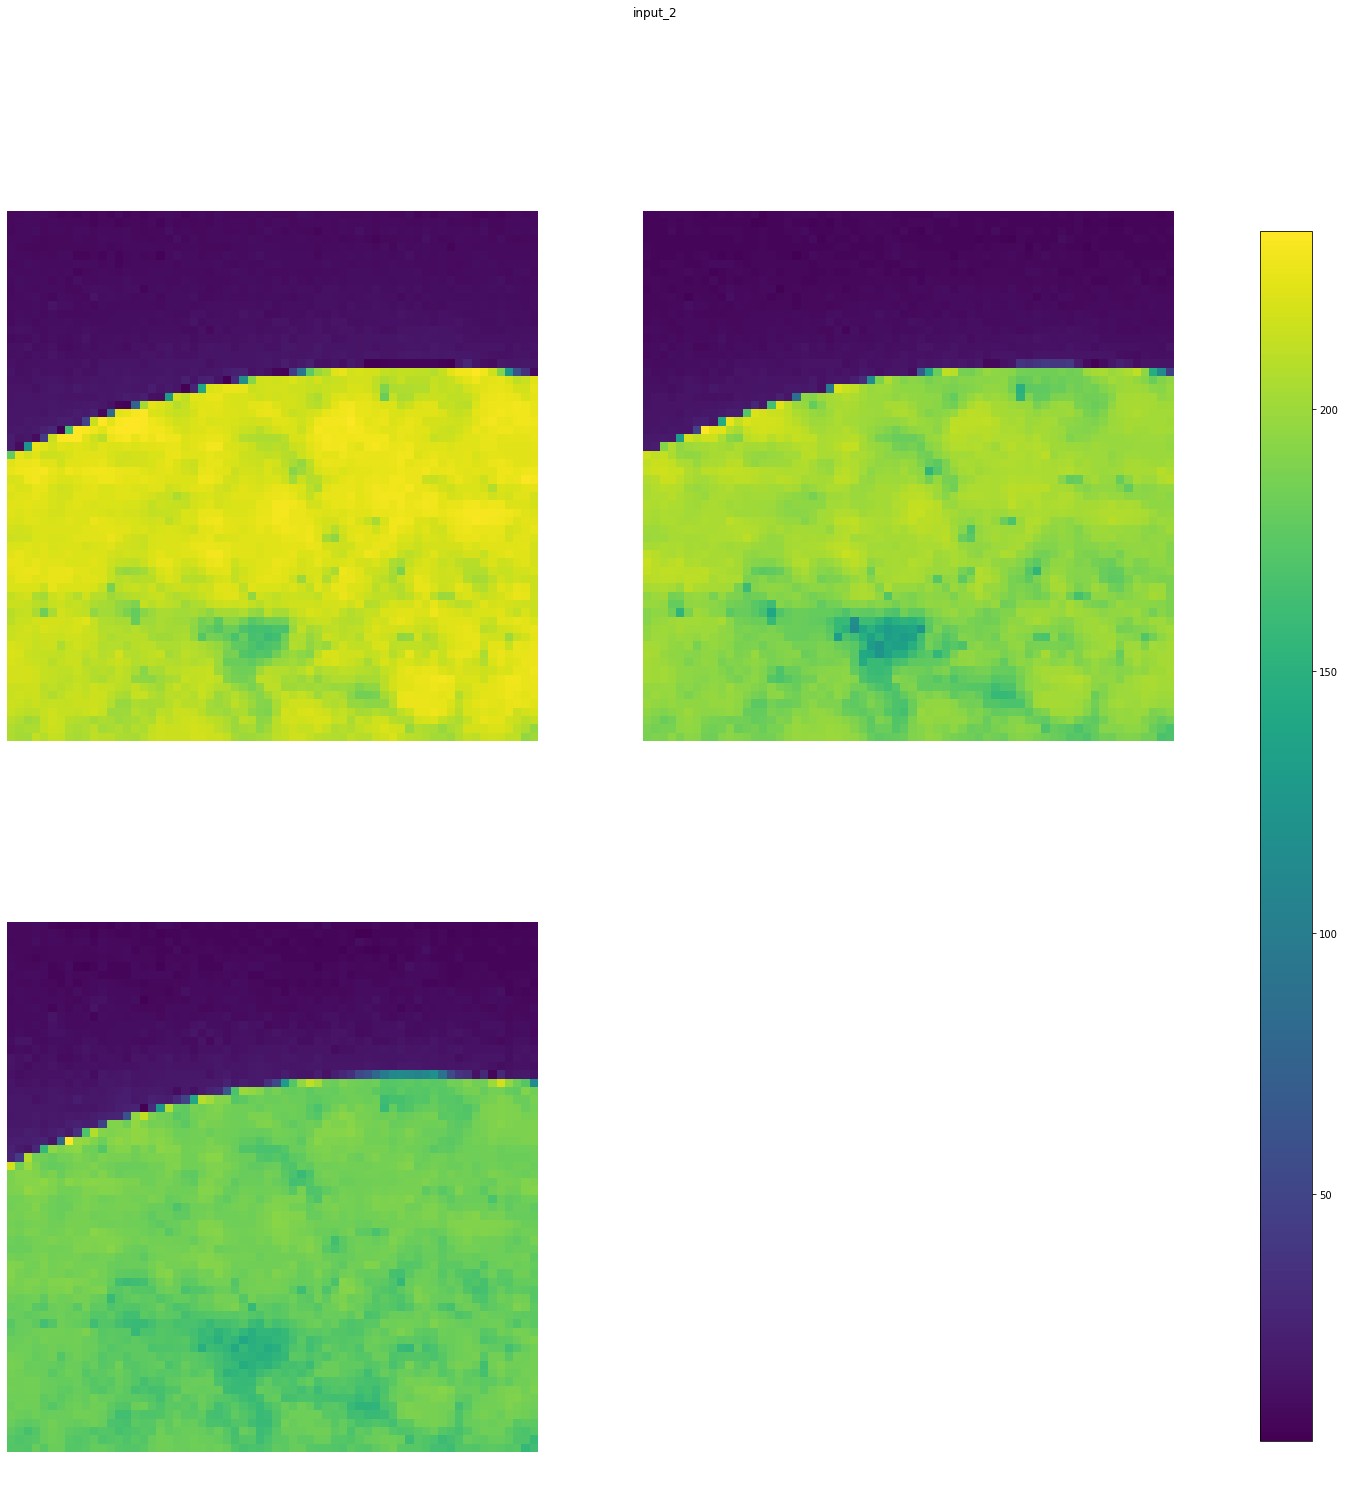

block1_conv1 (1, 64, 64, 64) 


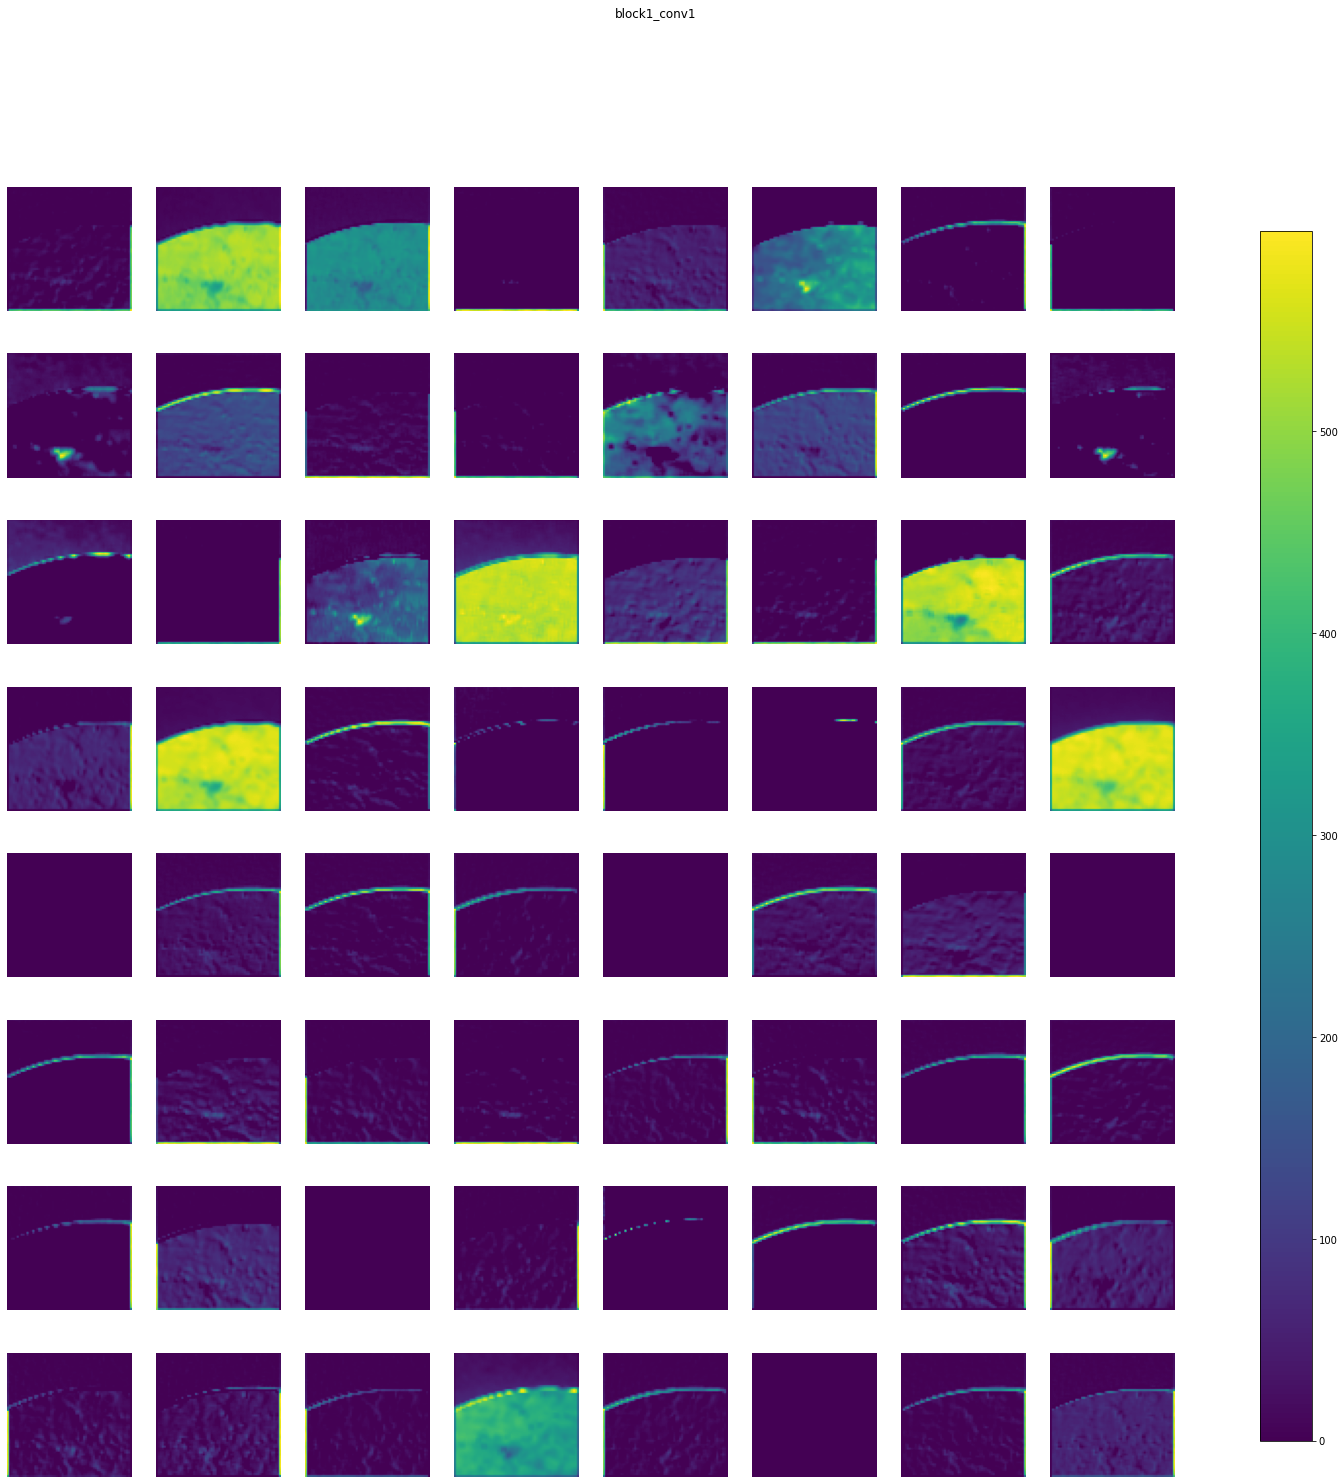

block1_conv2 (1, 64, 64, 64) 


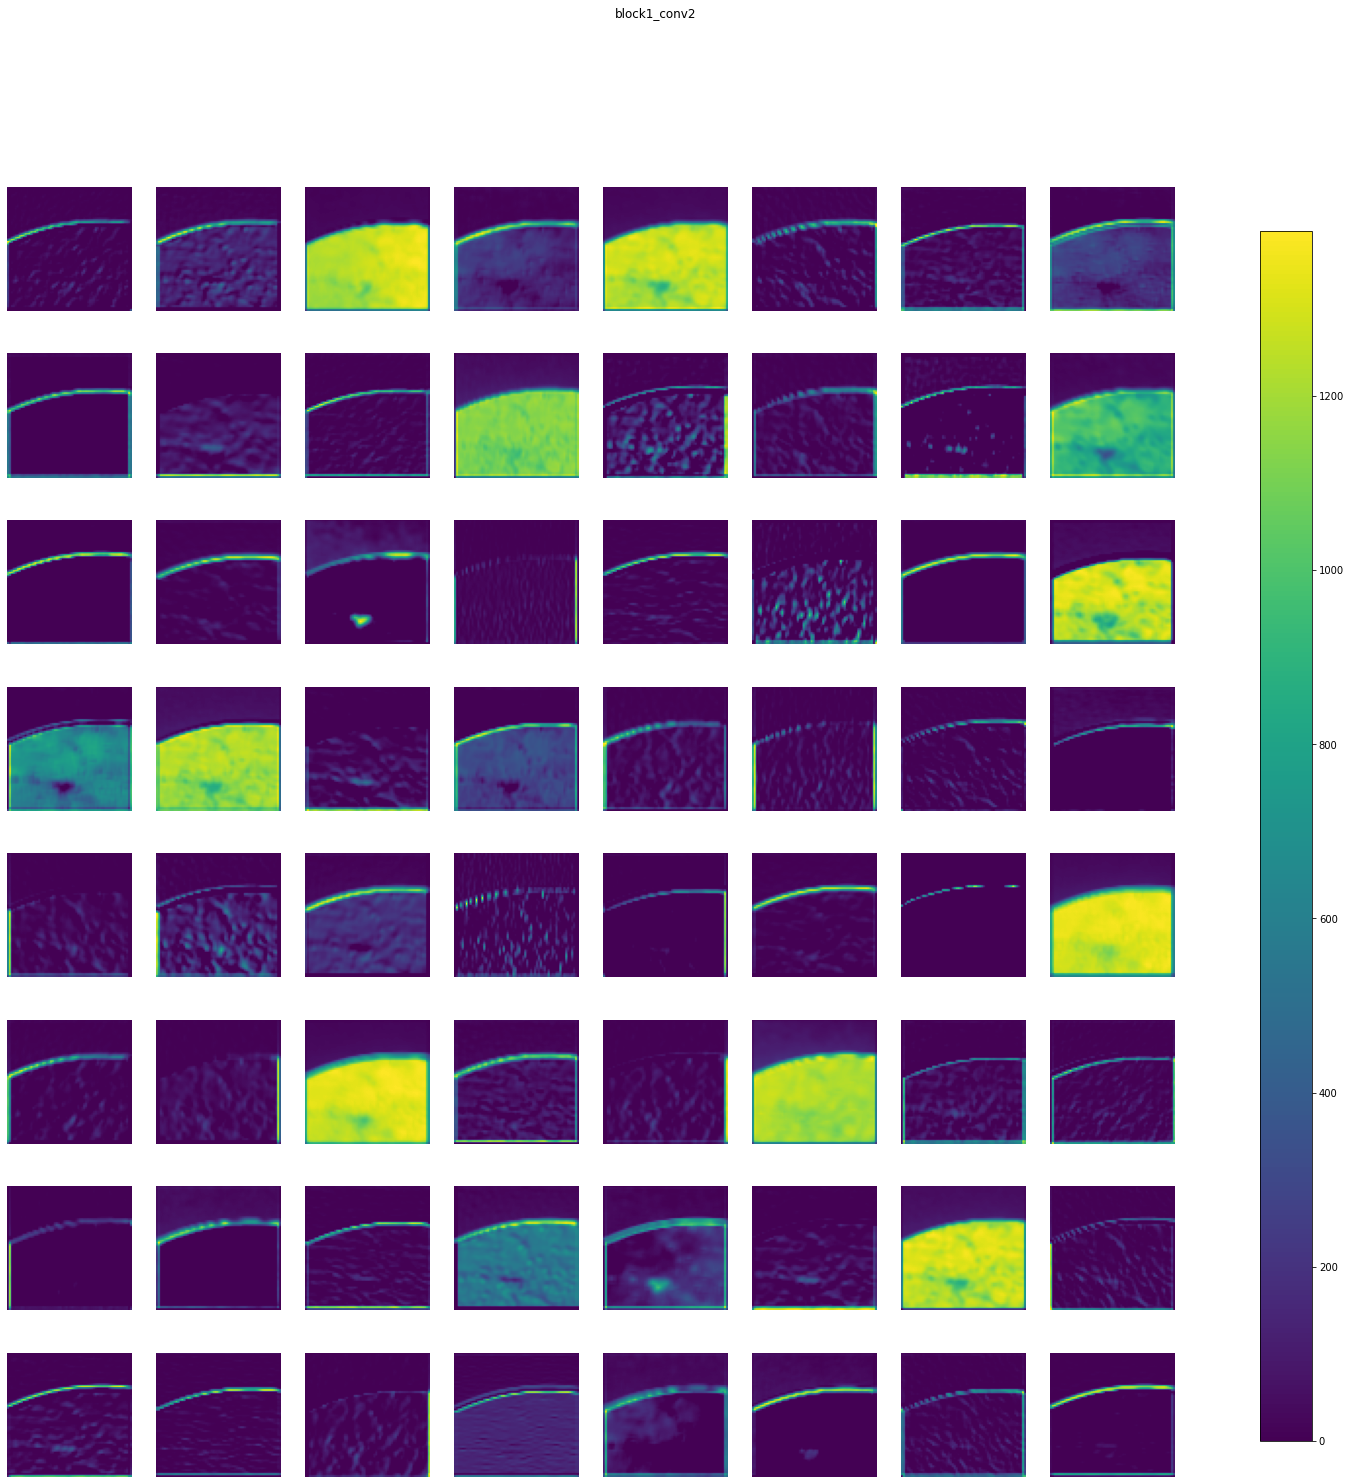

block1_pool (1, 32, 32, 64) 


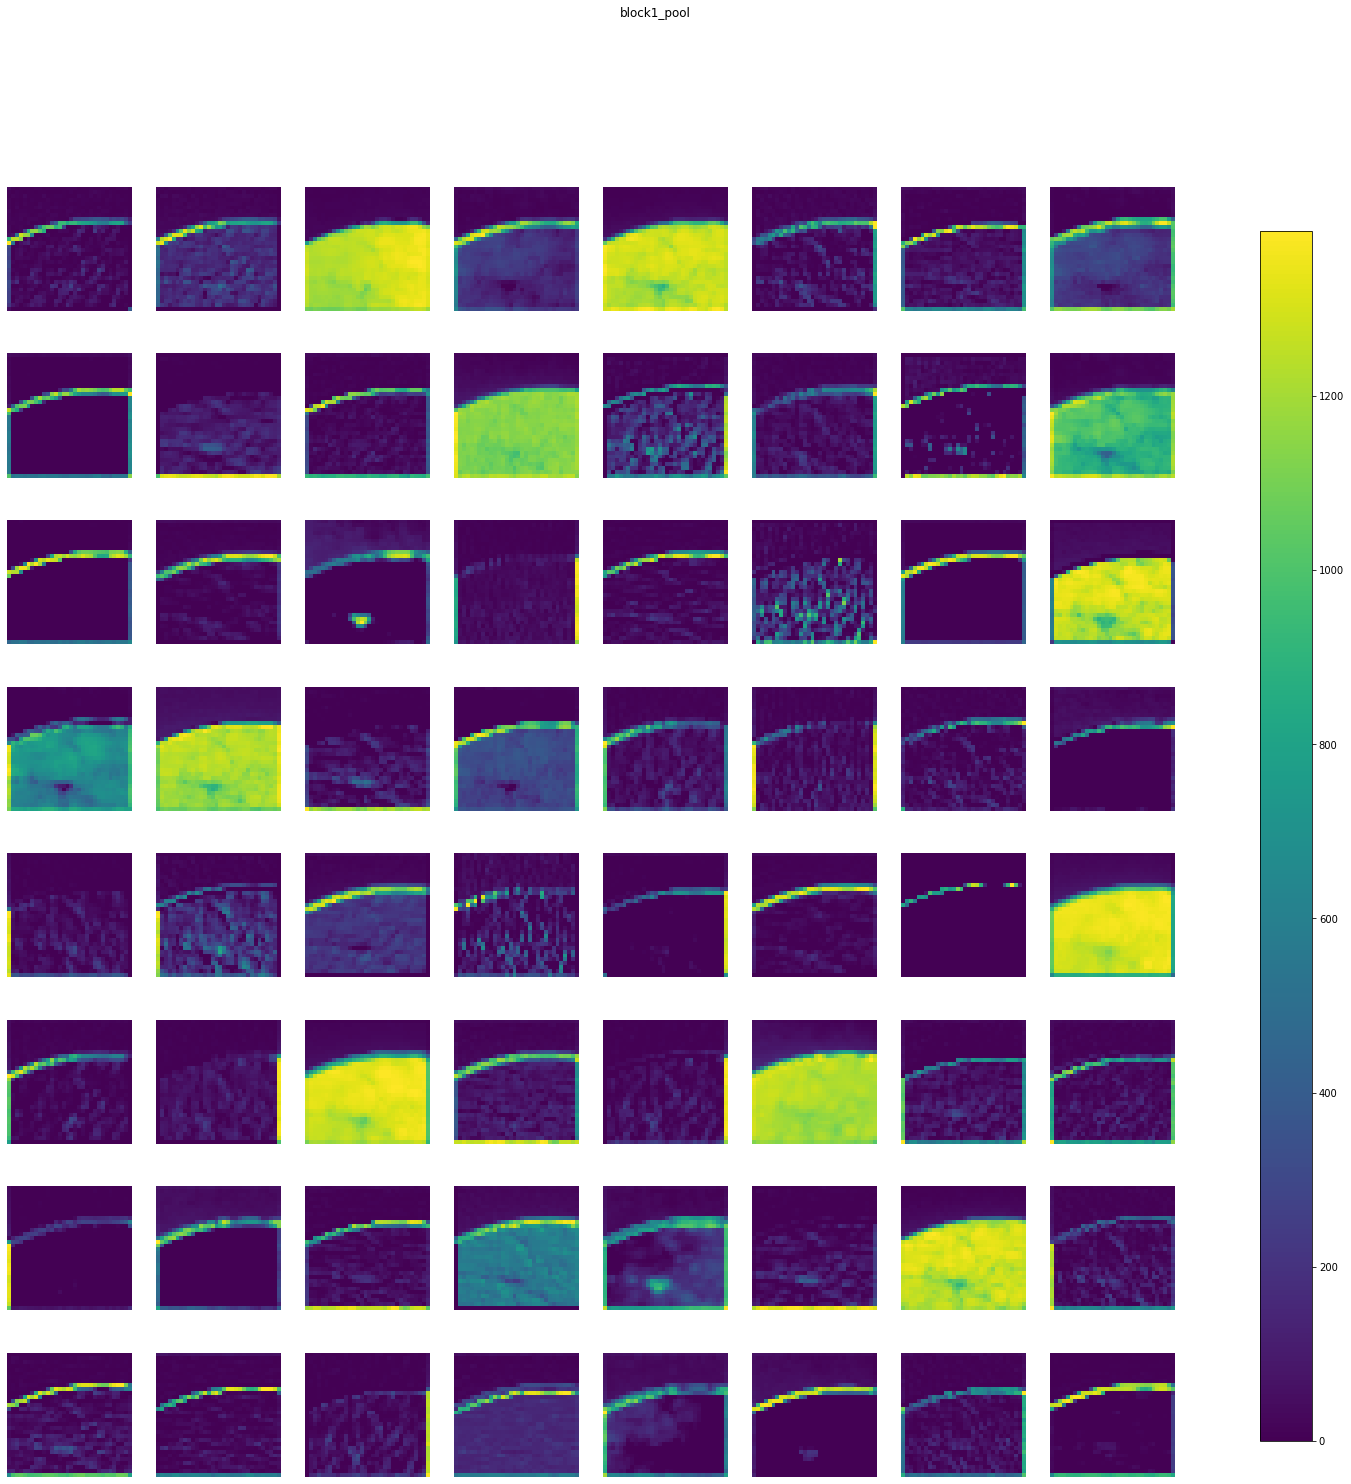

block2_conv1 (1, 32, 32, 128) 


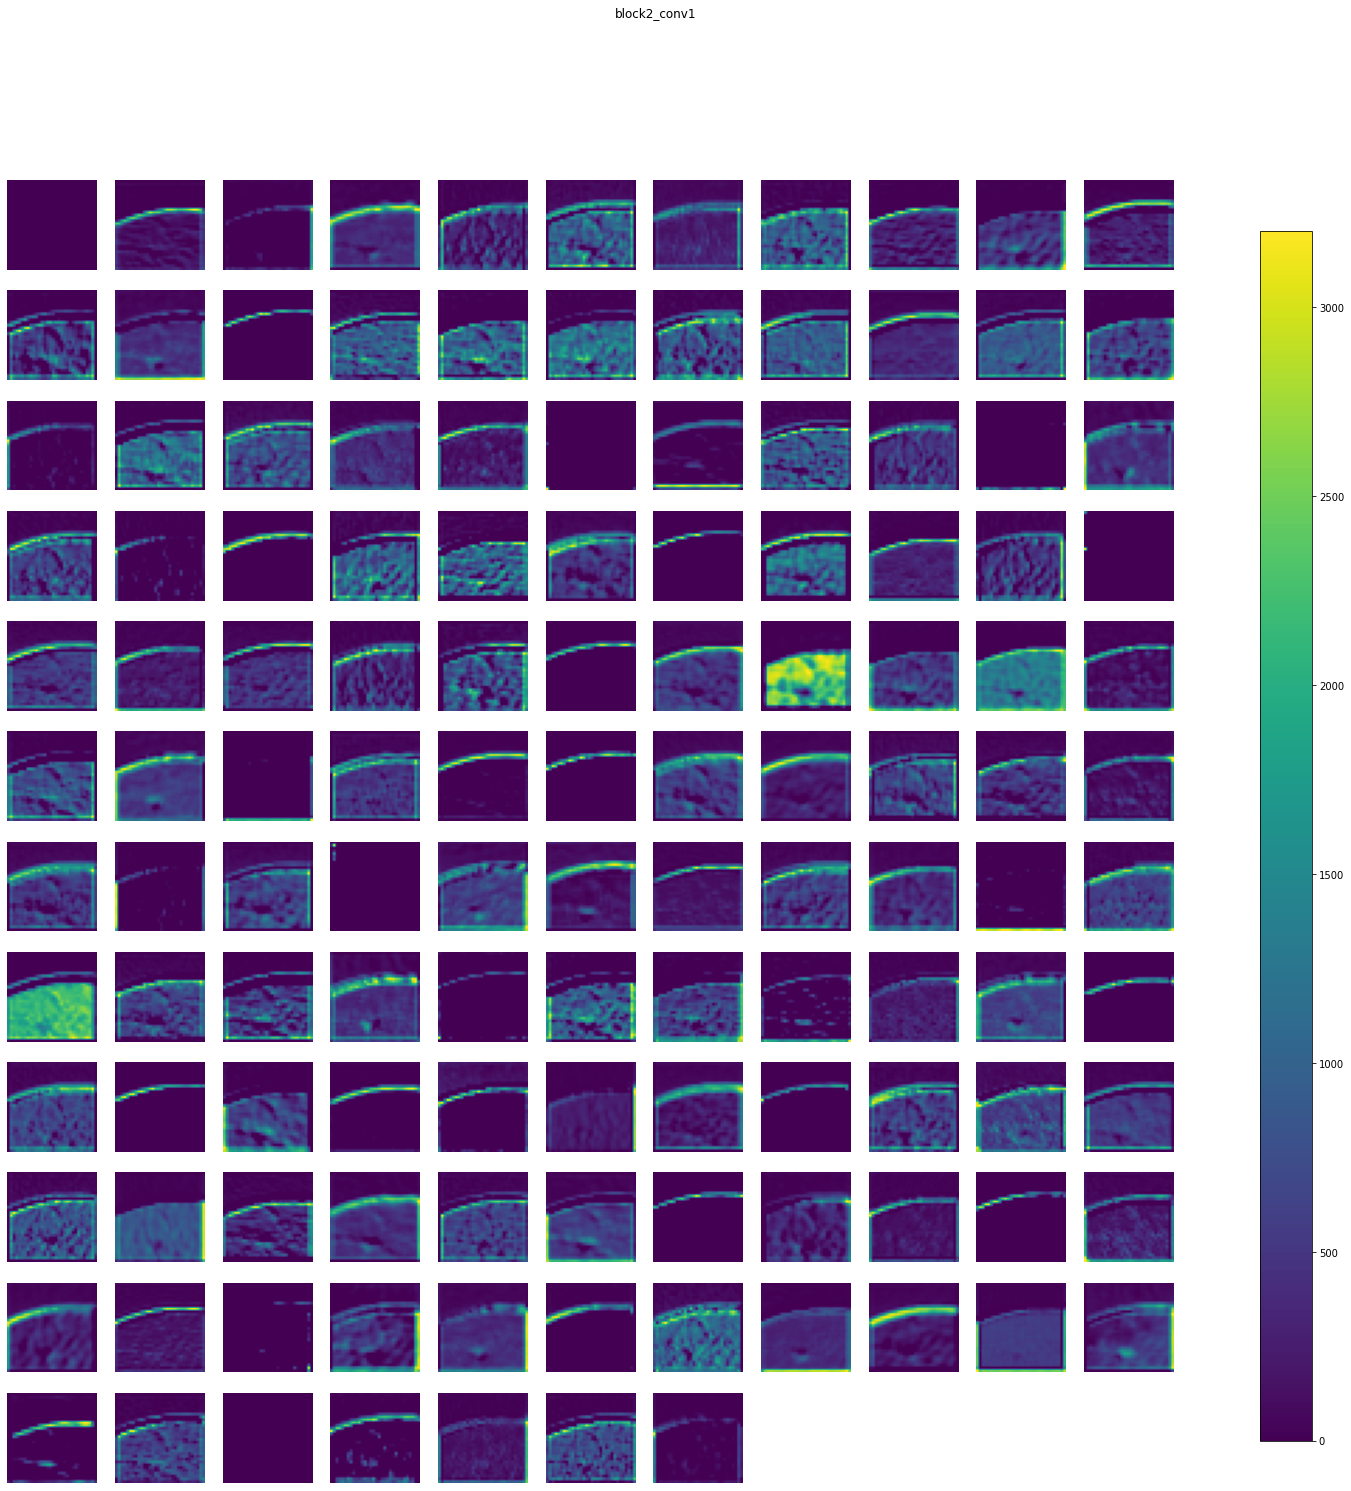

block2_conv2 (1, 32, 32, 128) 


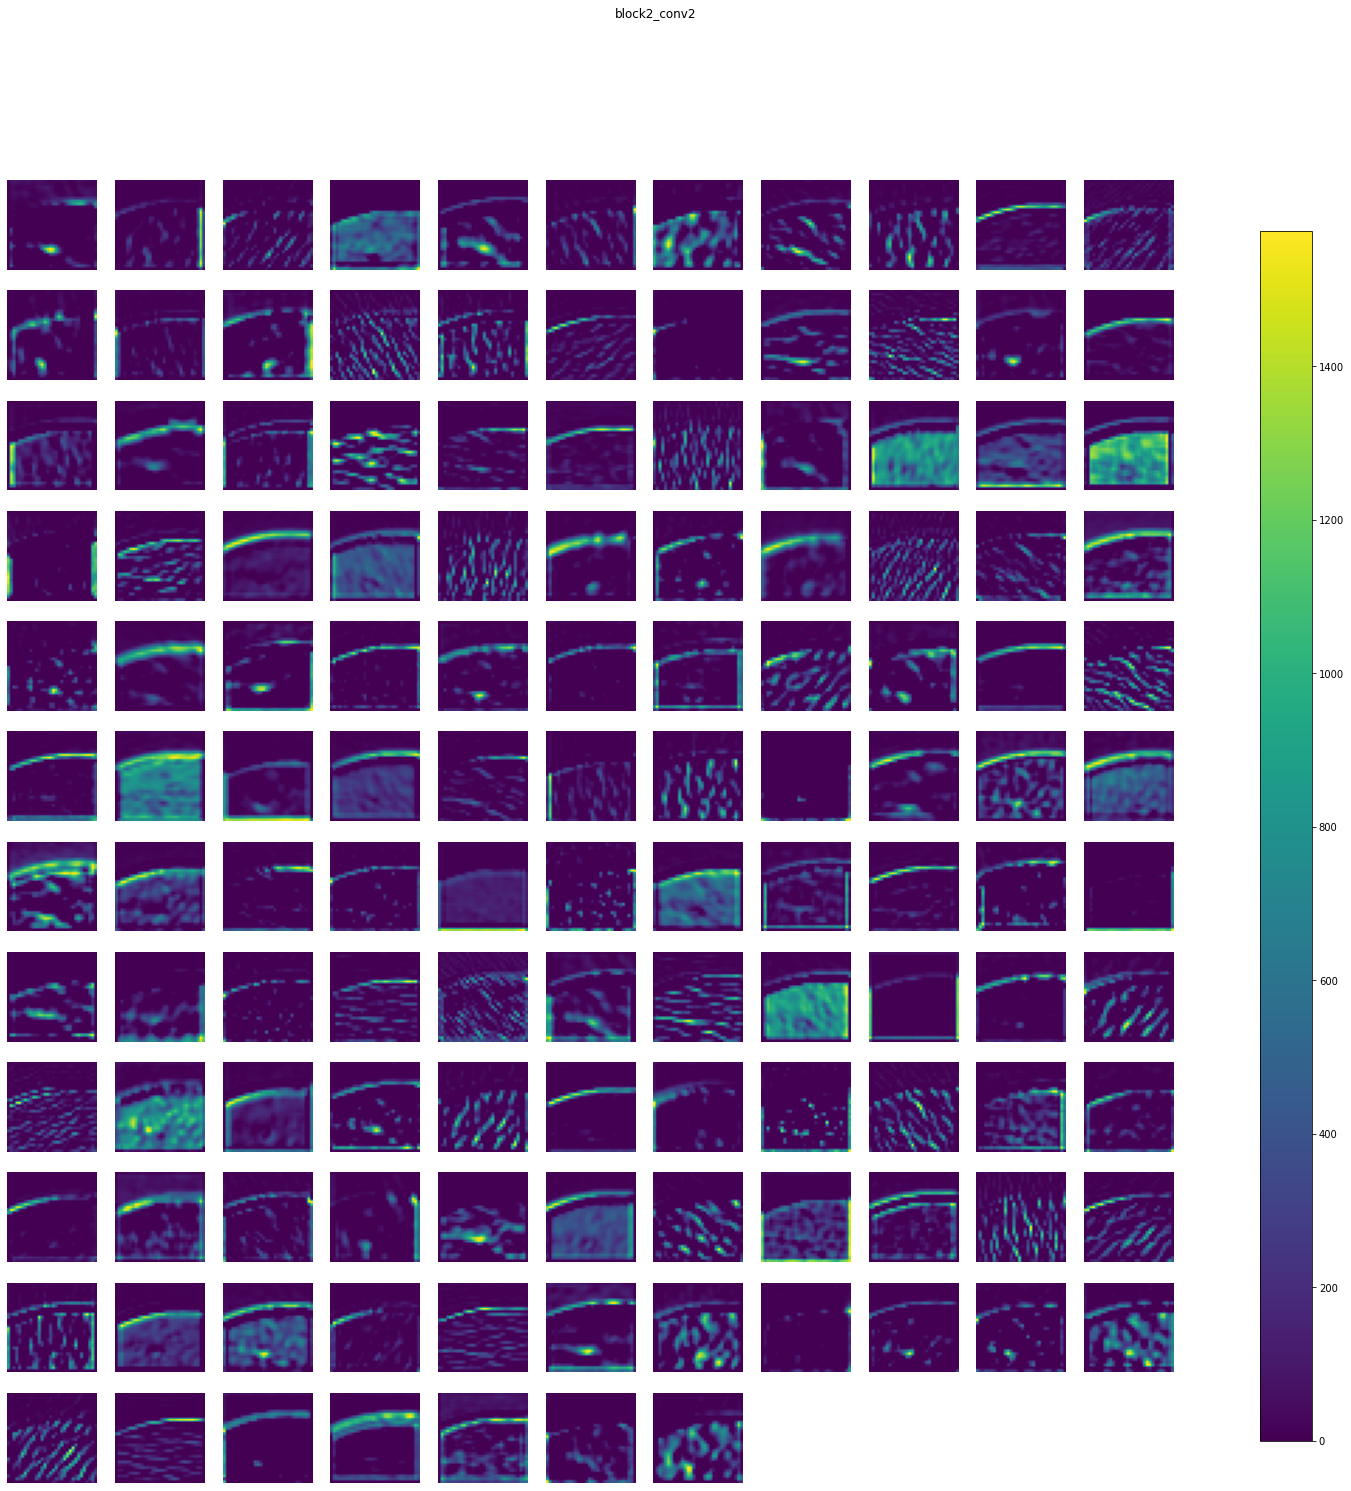

block2_pool (1, 16, 16, 128) 


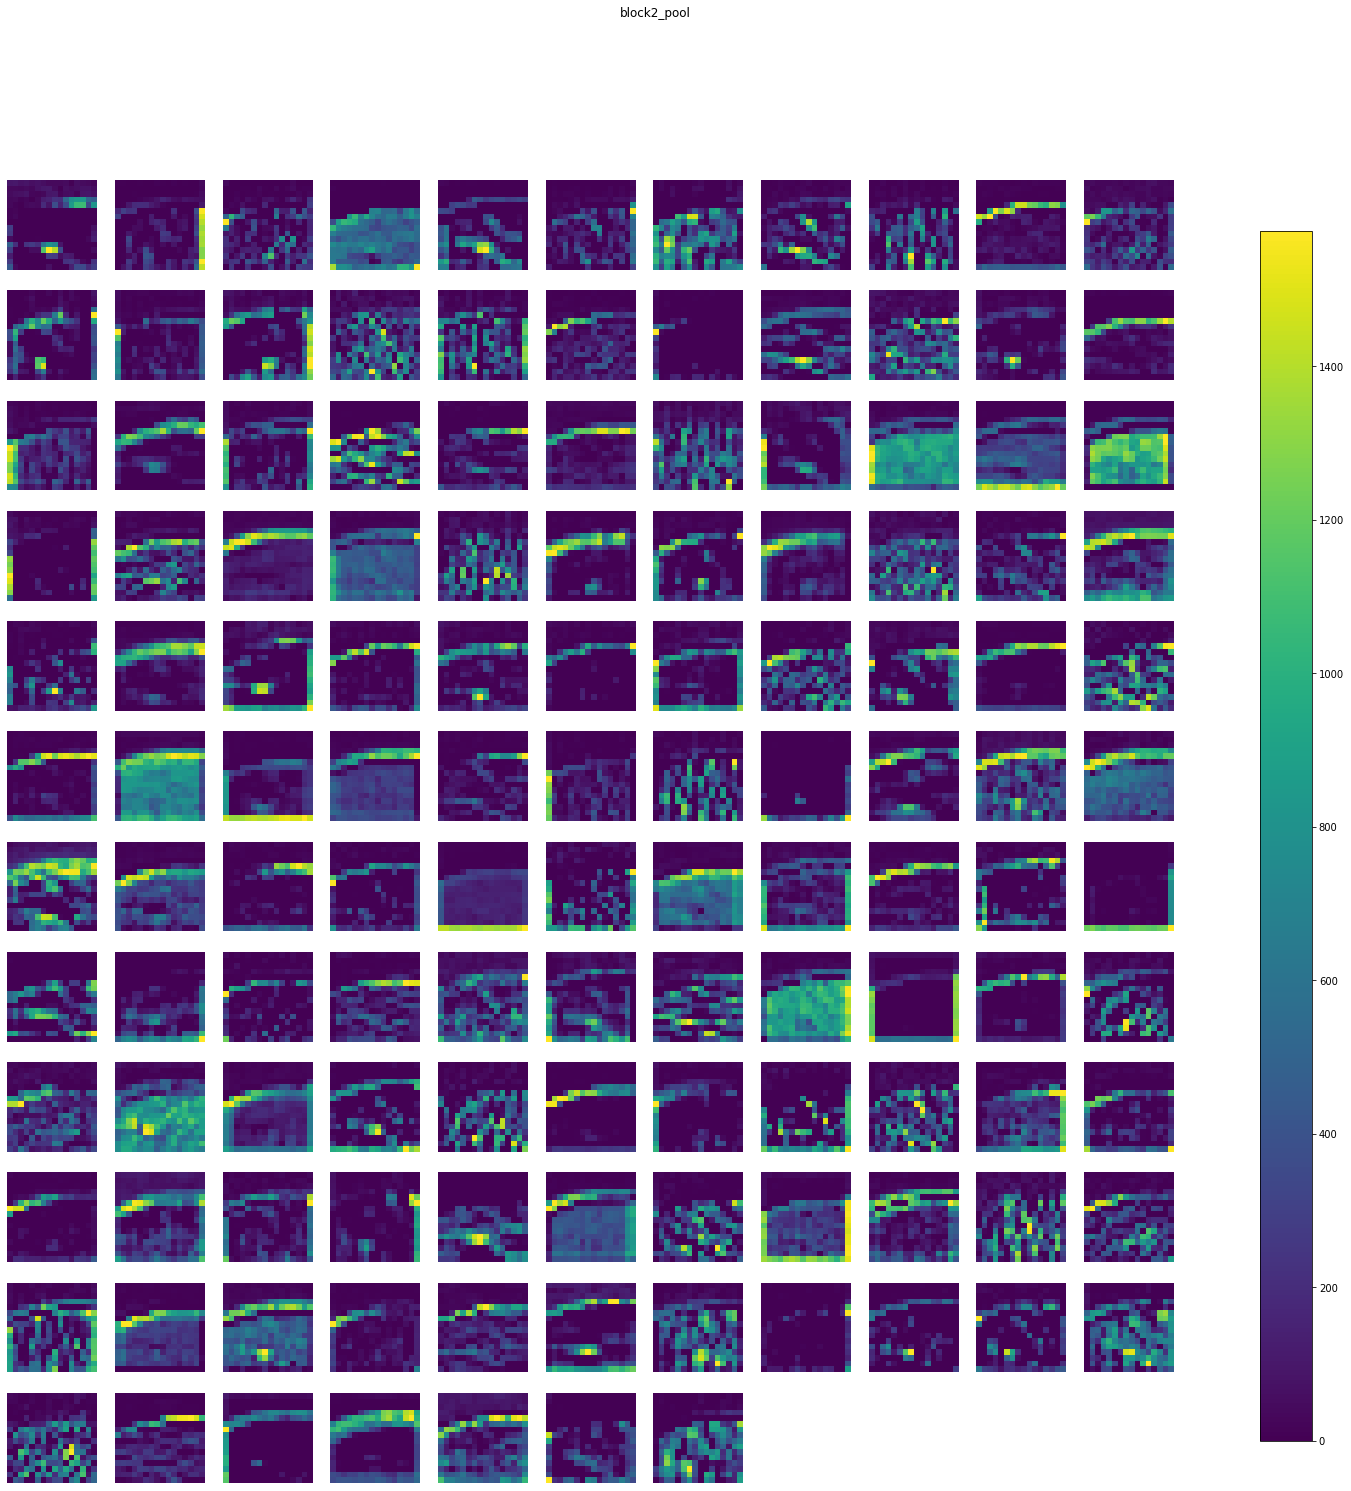

block3_conv1 (1, 16, 16, 256) 


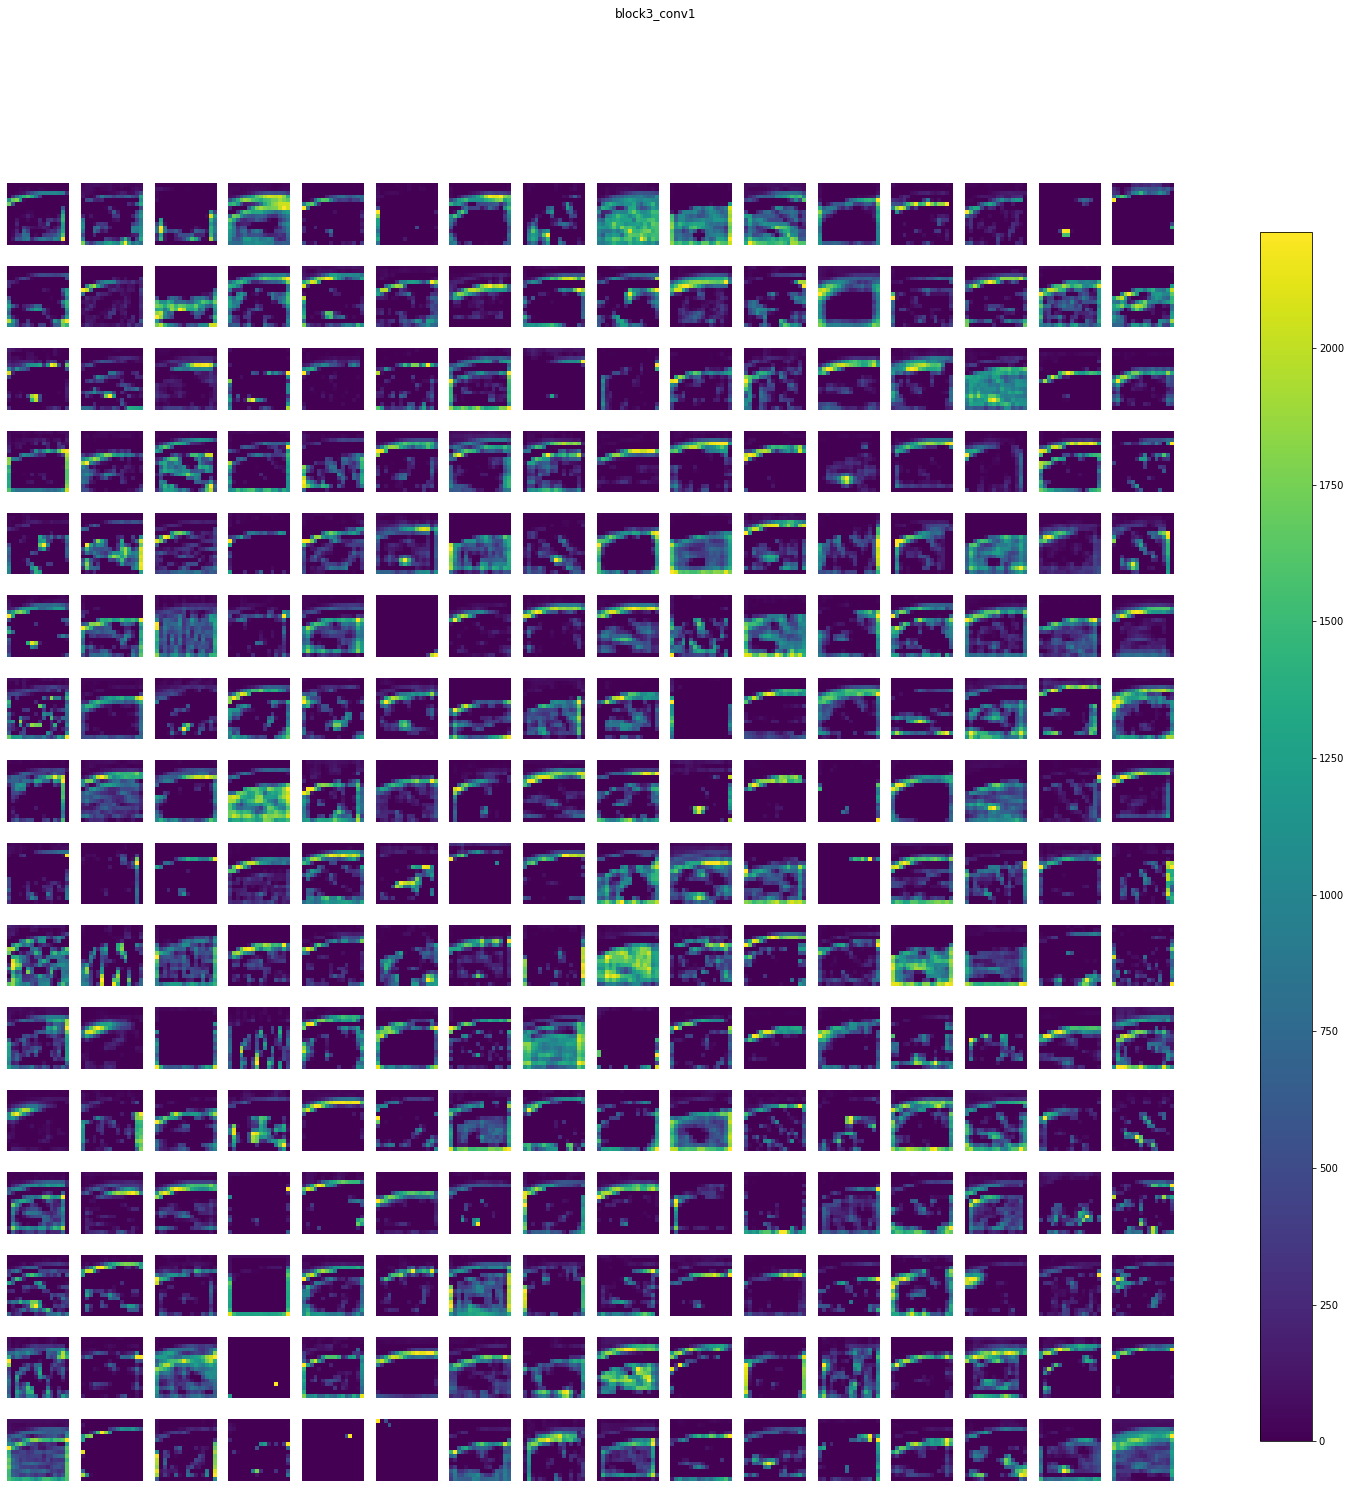

block3_conv2 (1, 16, 16, 256) 


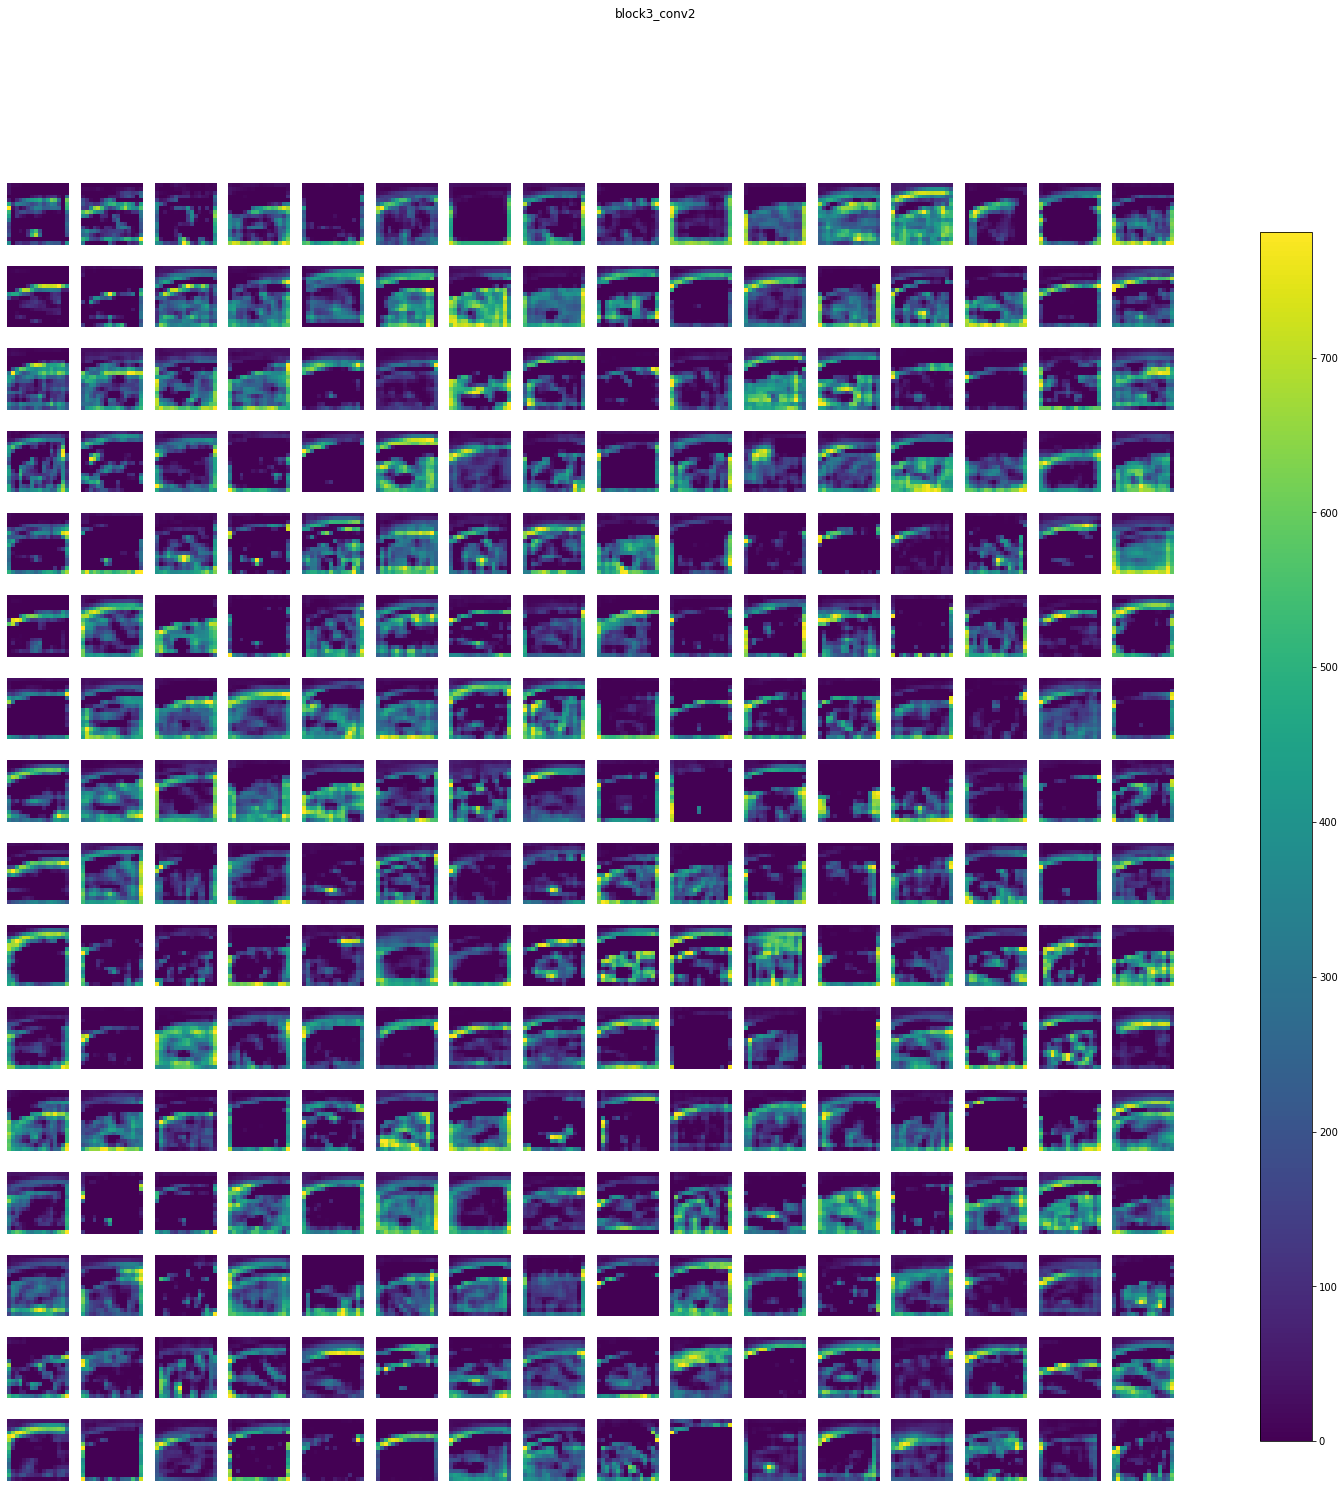

block3_conv3 (1, 16, 16, 256) 


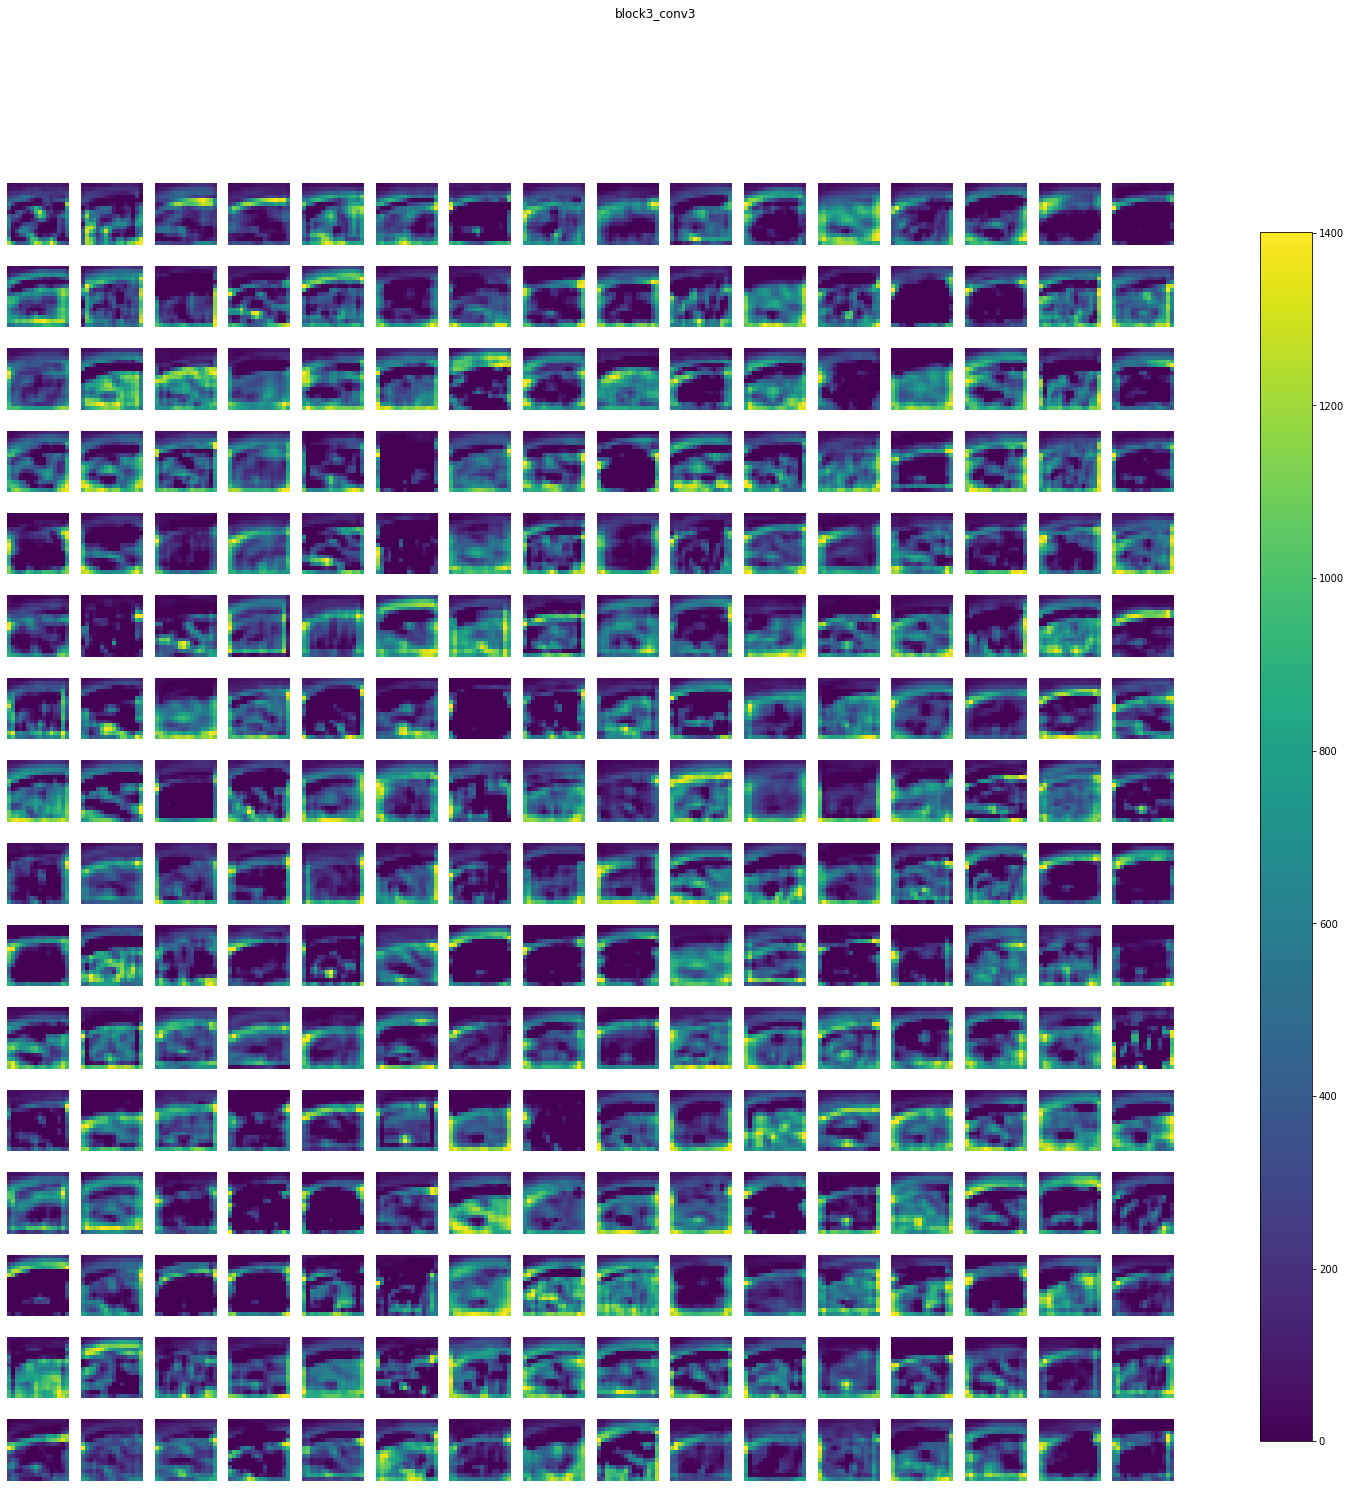

block3_conv4 (1, 16, 16, 256) 


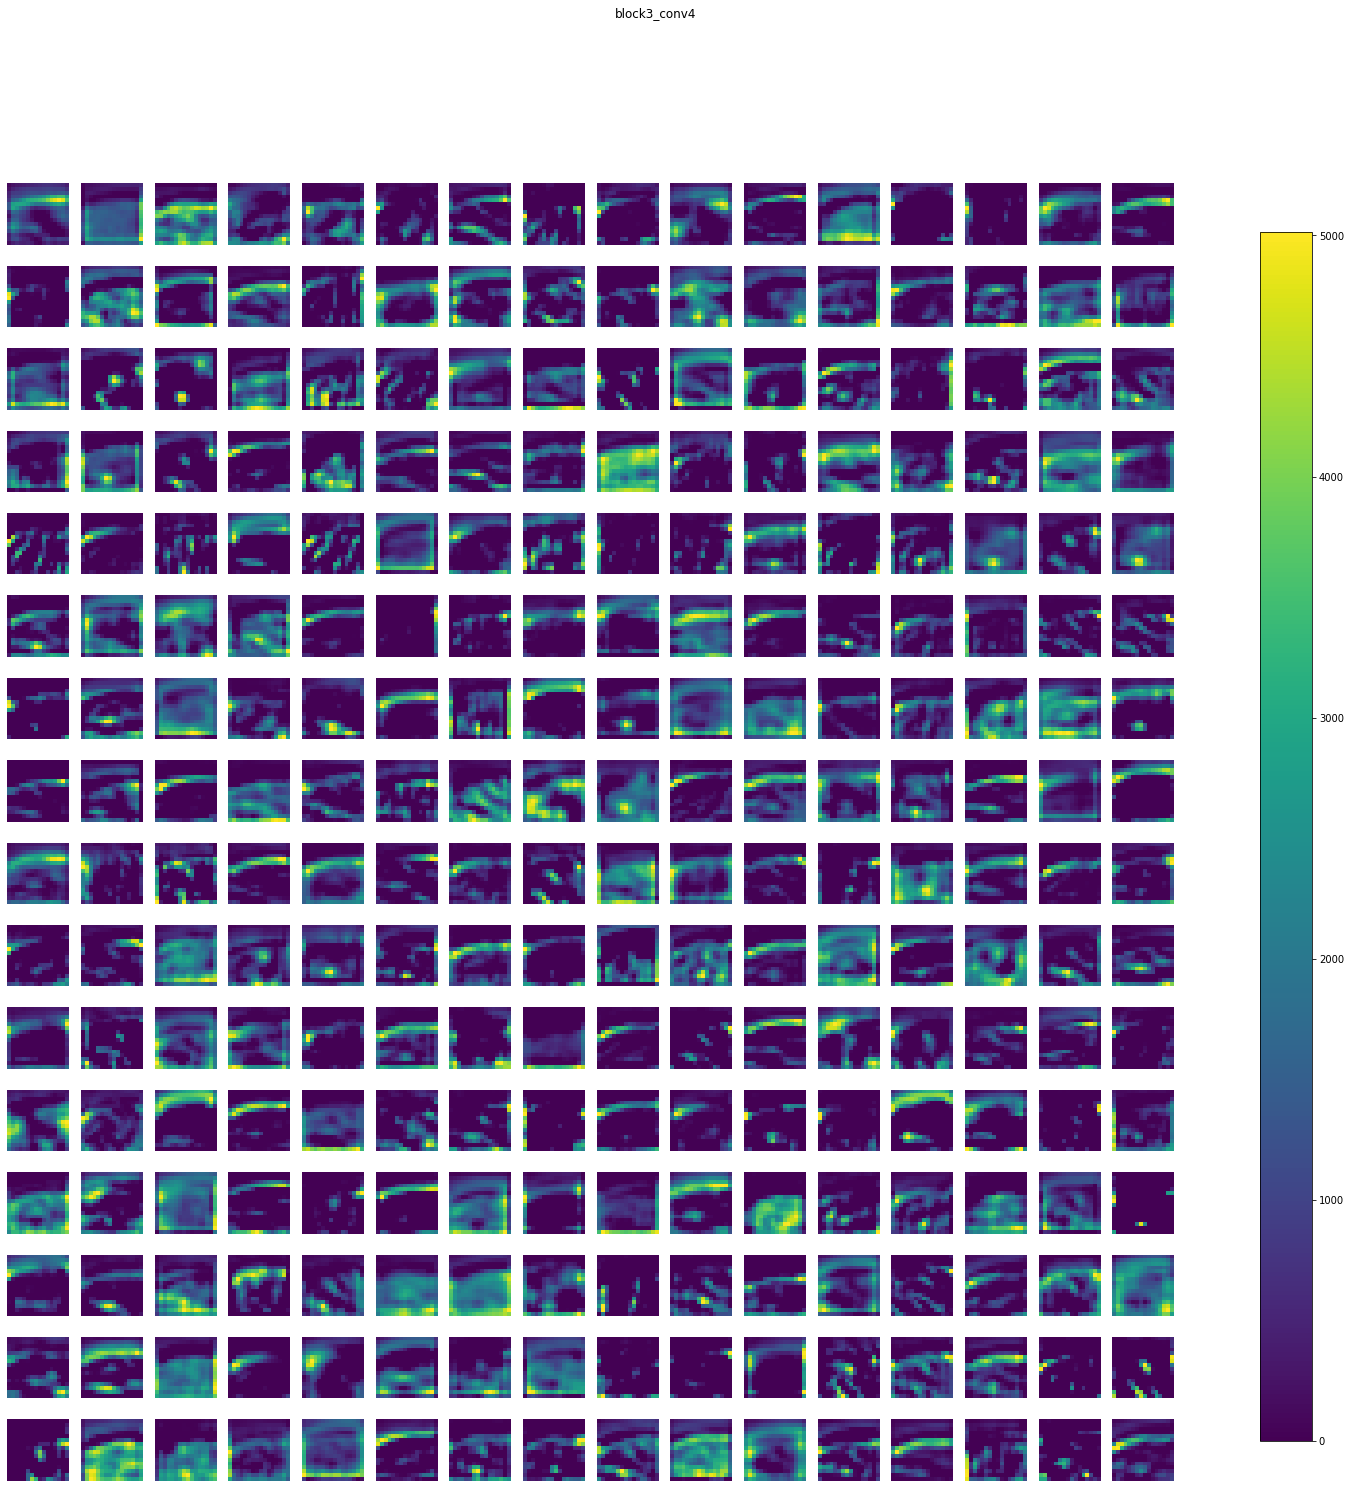

block3_pool (1, 8, 8, 256) 


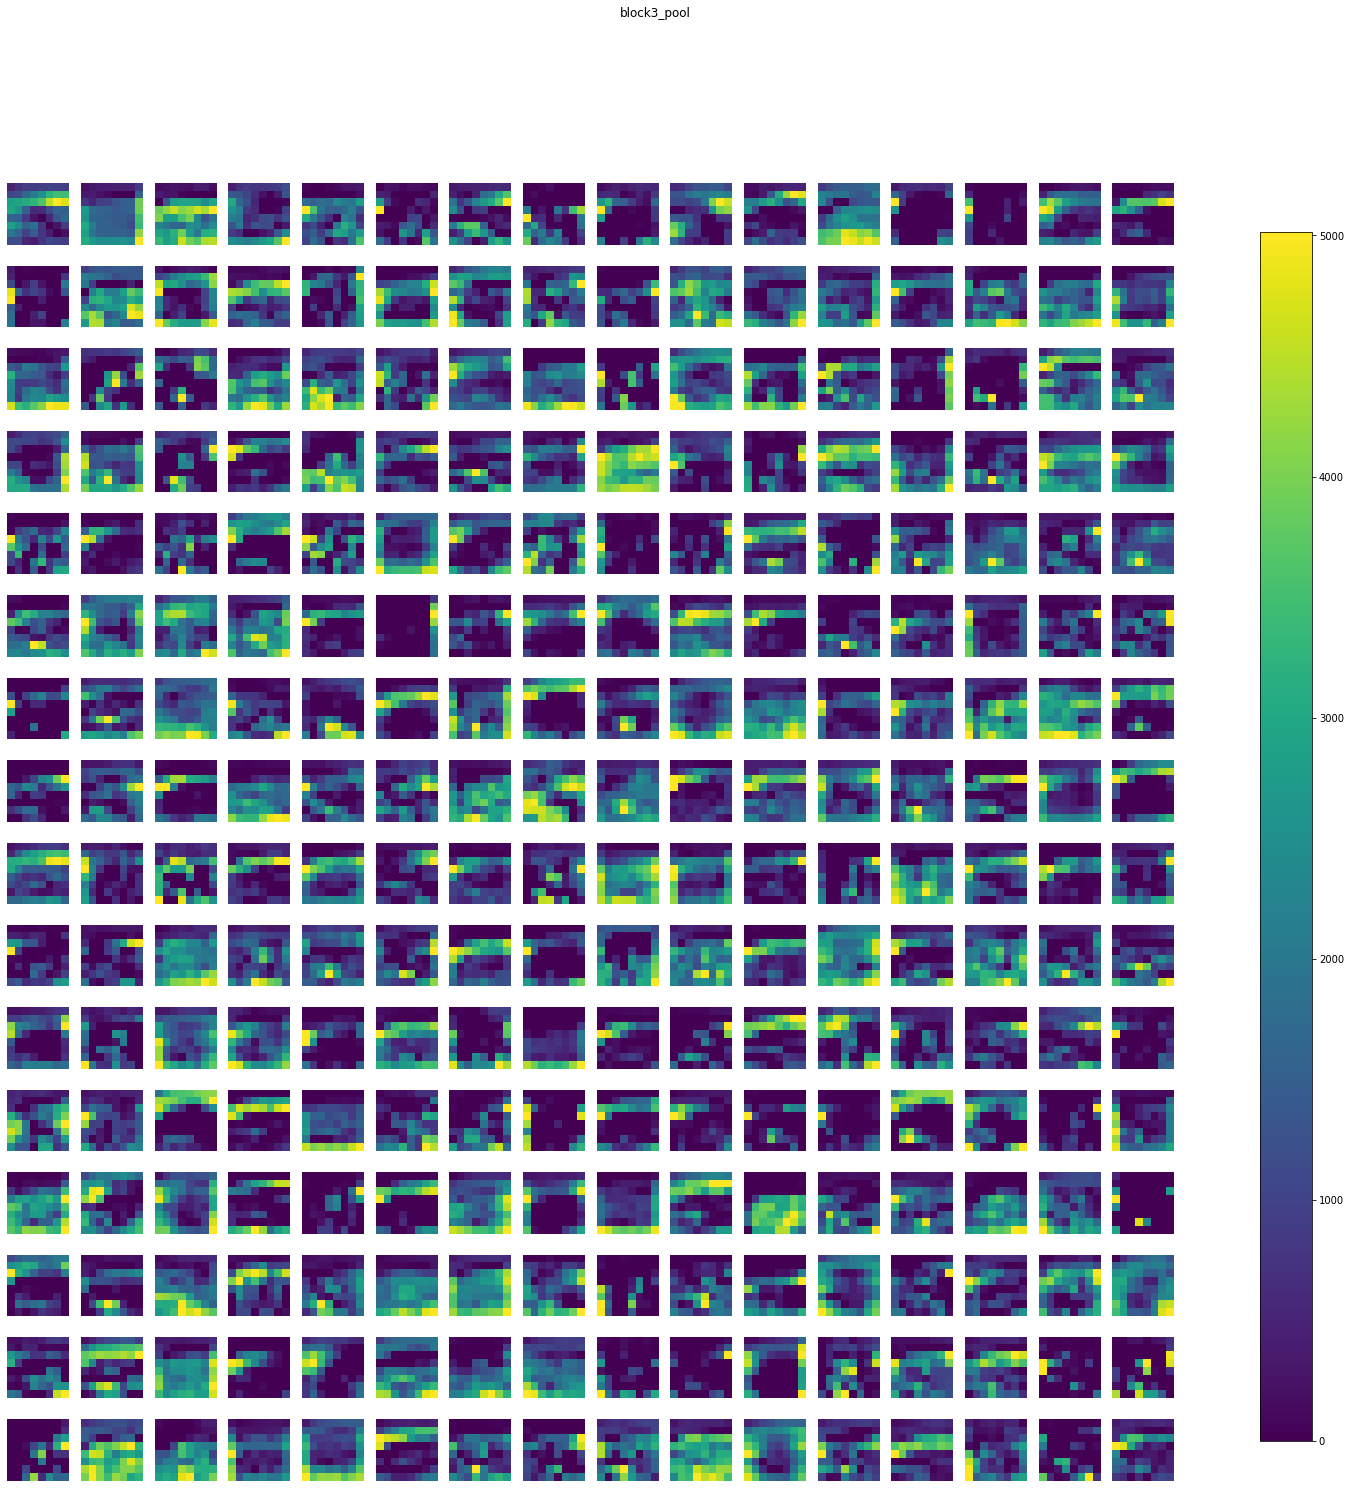

block4_conv1 (1, 8, 8, 512) 


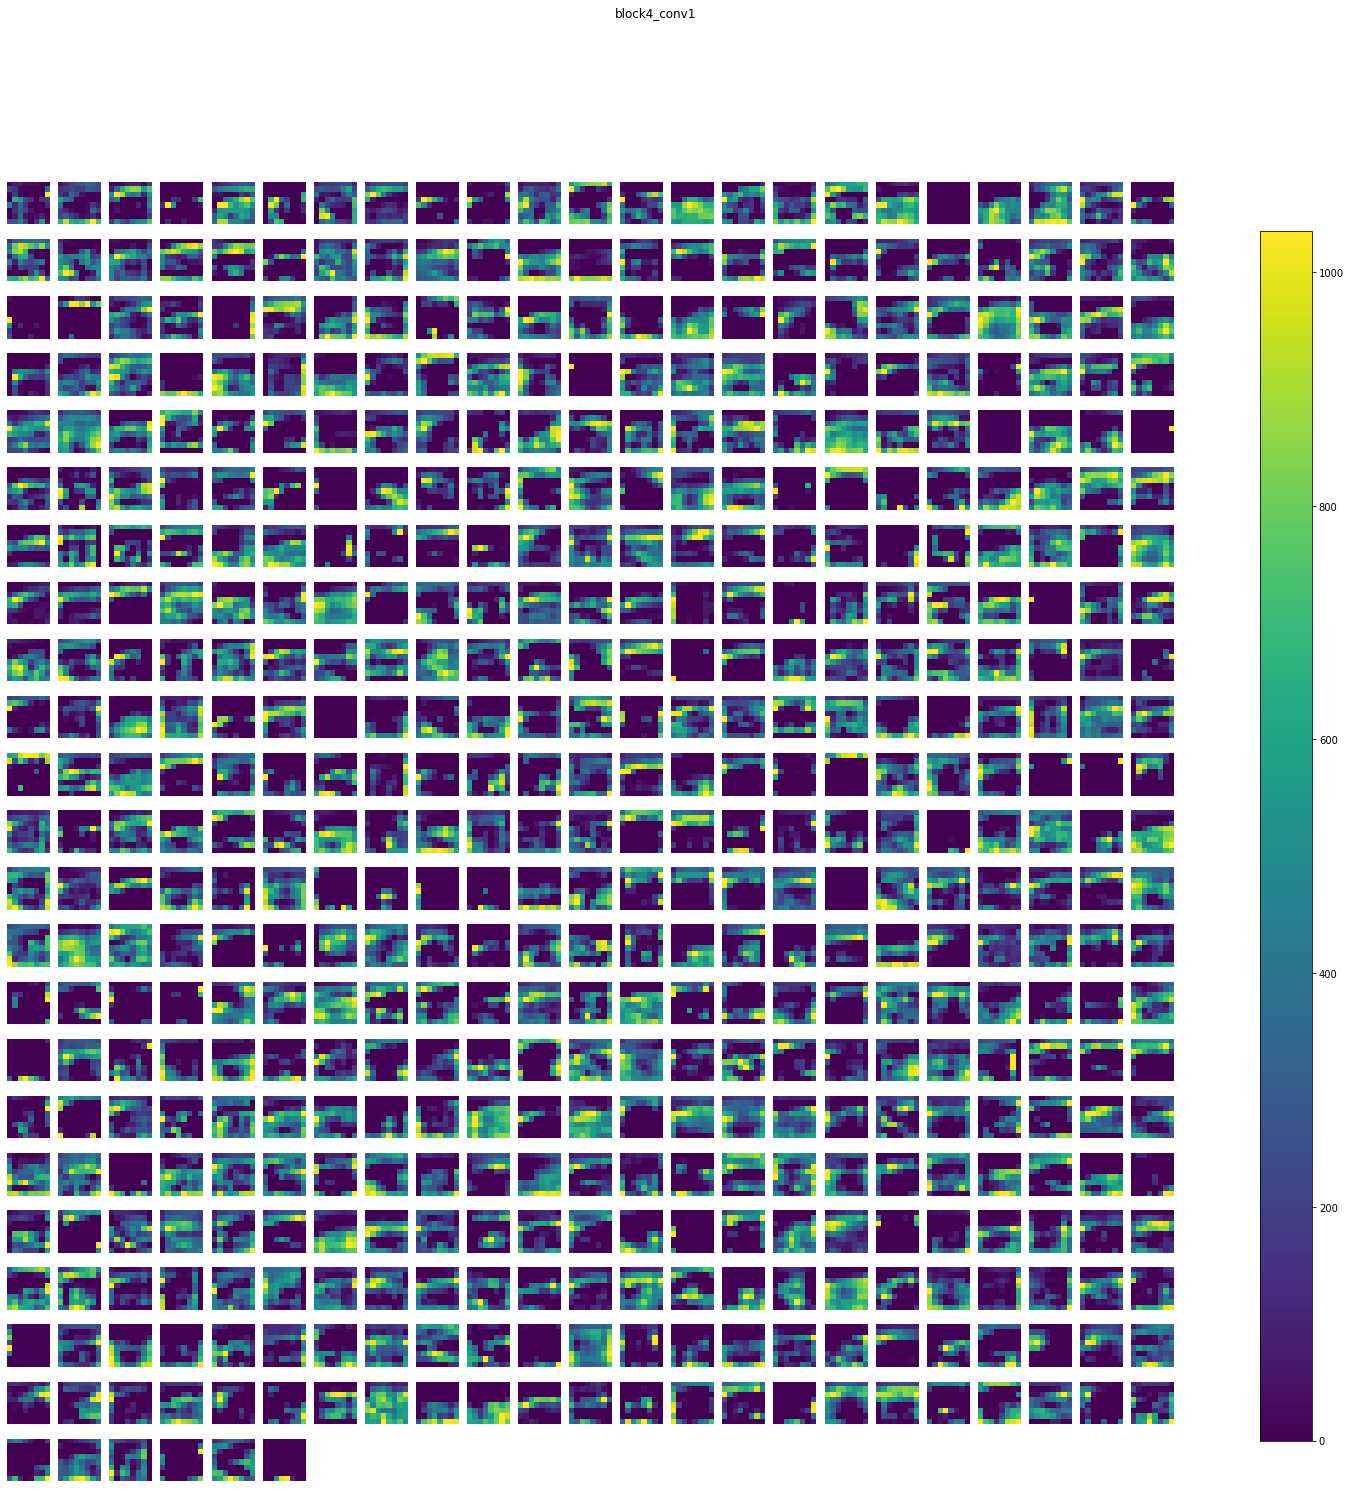

block4_conv2 (1, 8, 8, 512) 


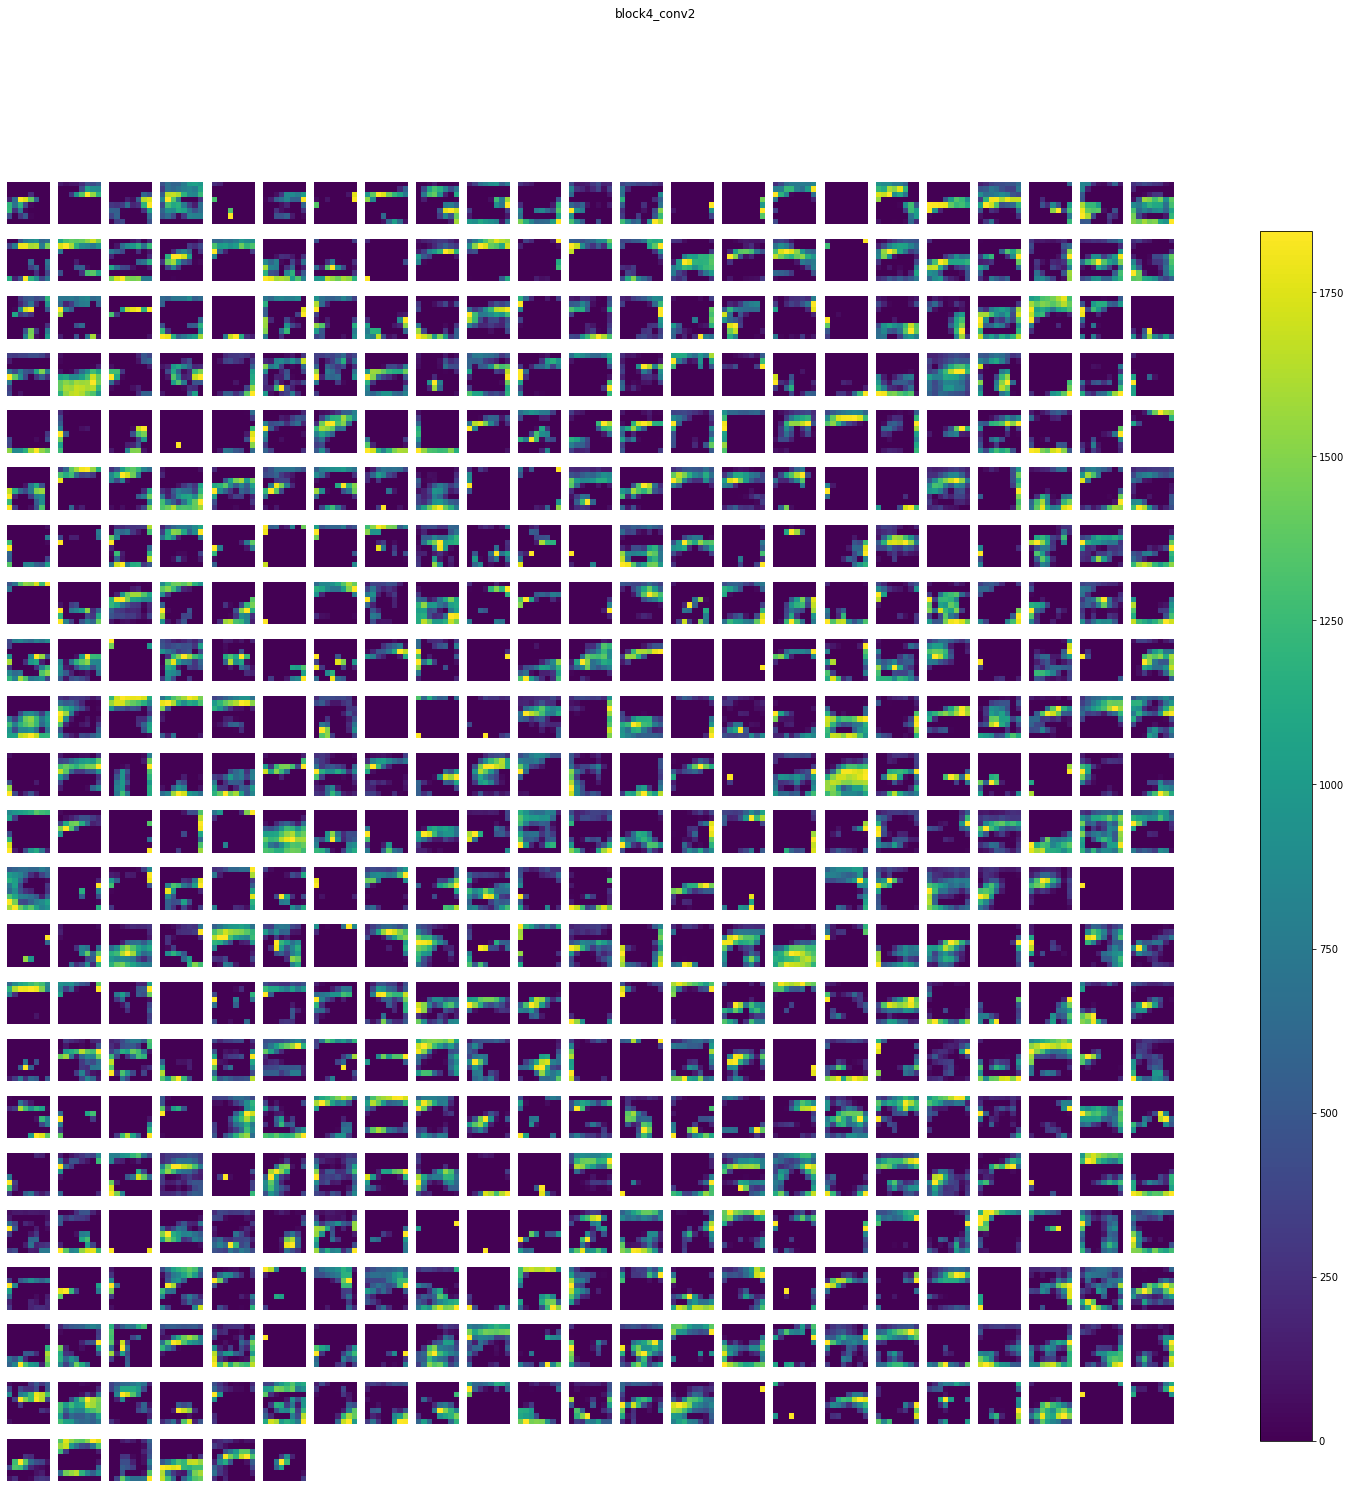

block4_conv3 (1, 8, 8, 512) 


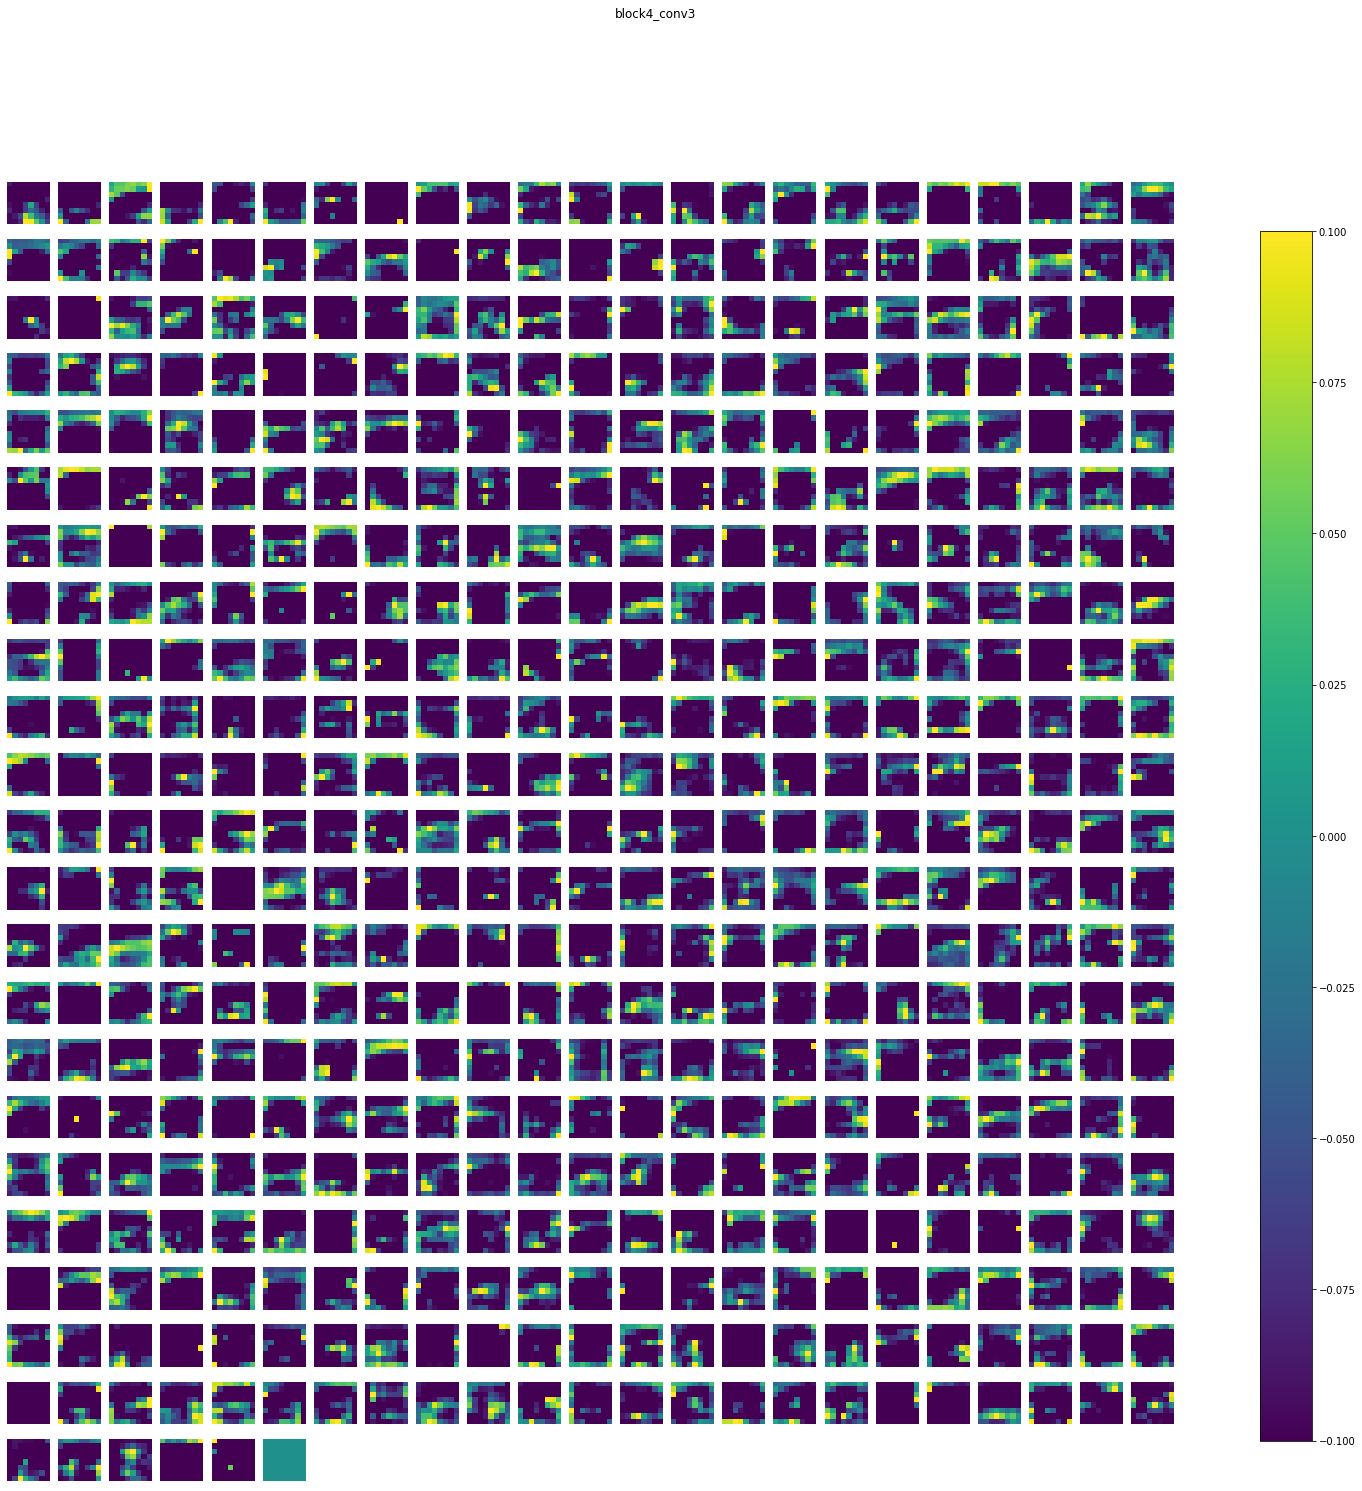

block4_conv4 (1, 8, 8, 512) 


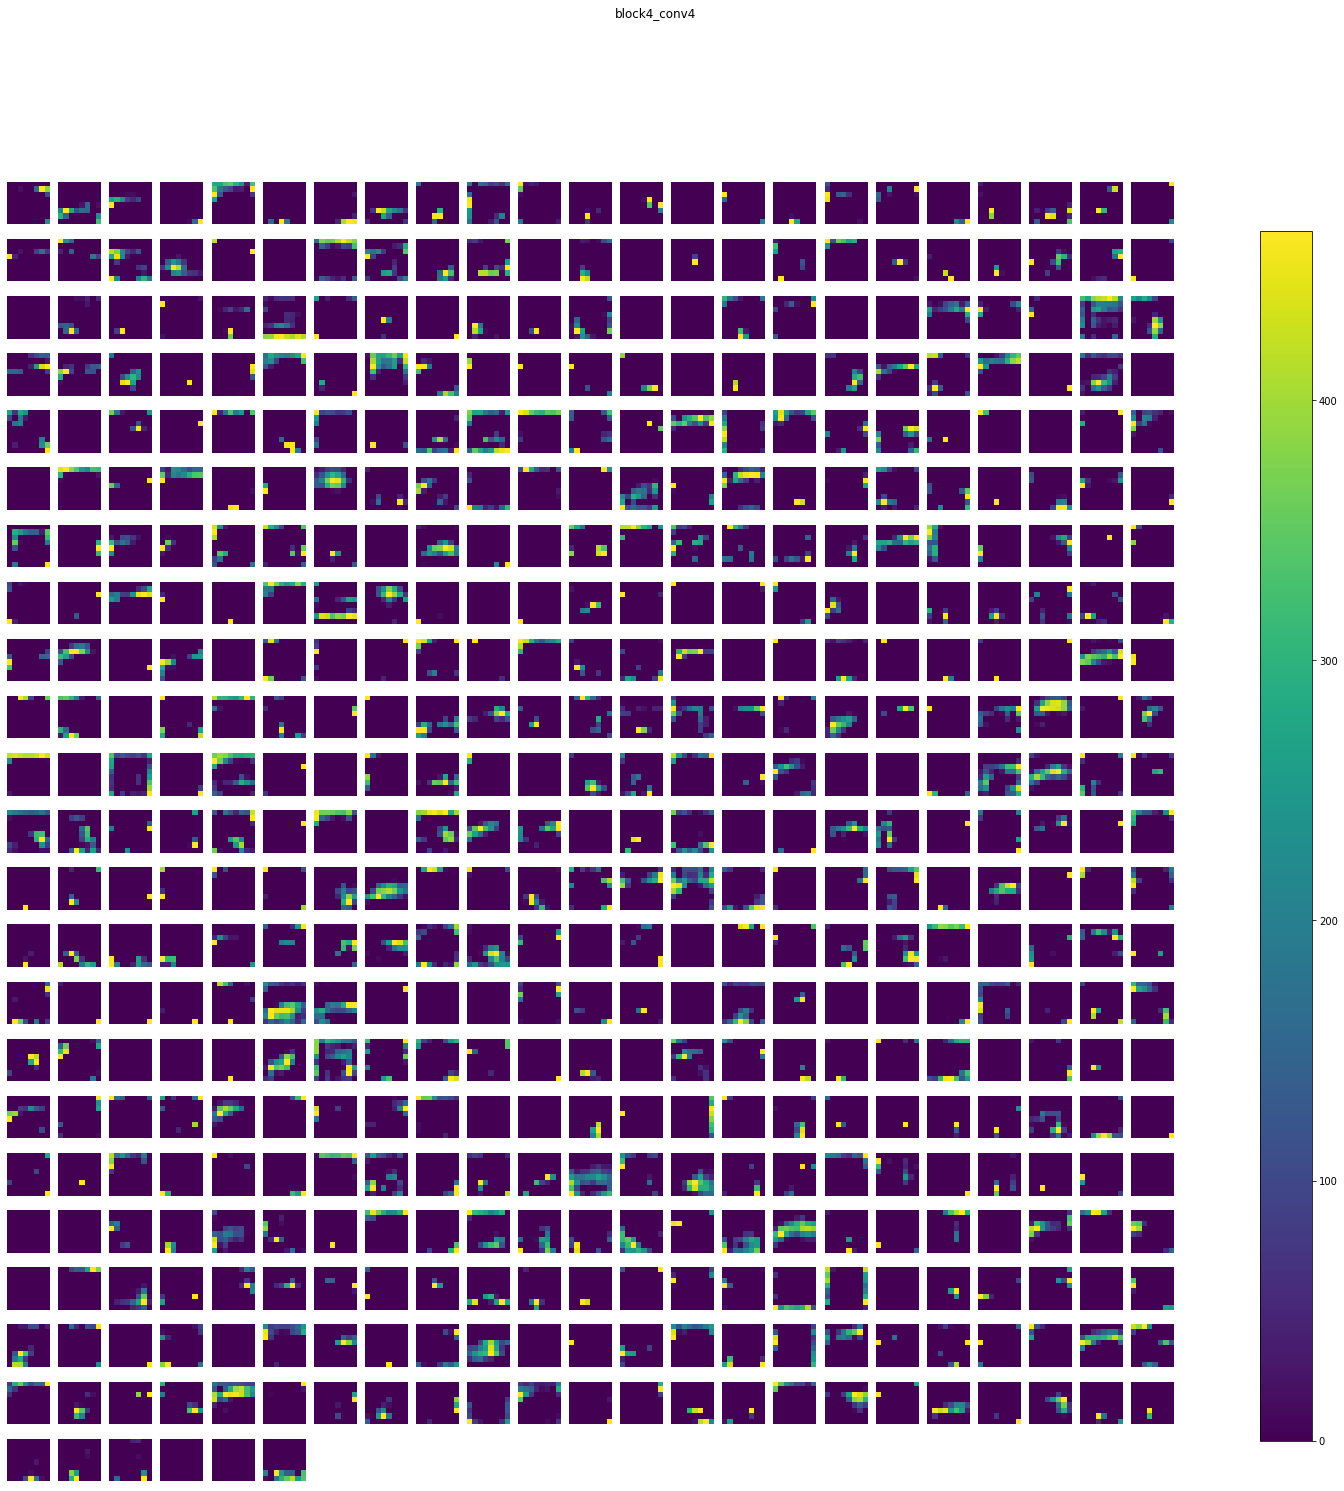

block4_pool (1, 4, 4, 512) 


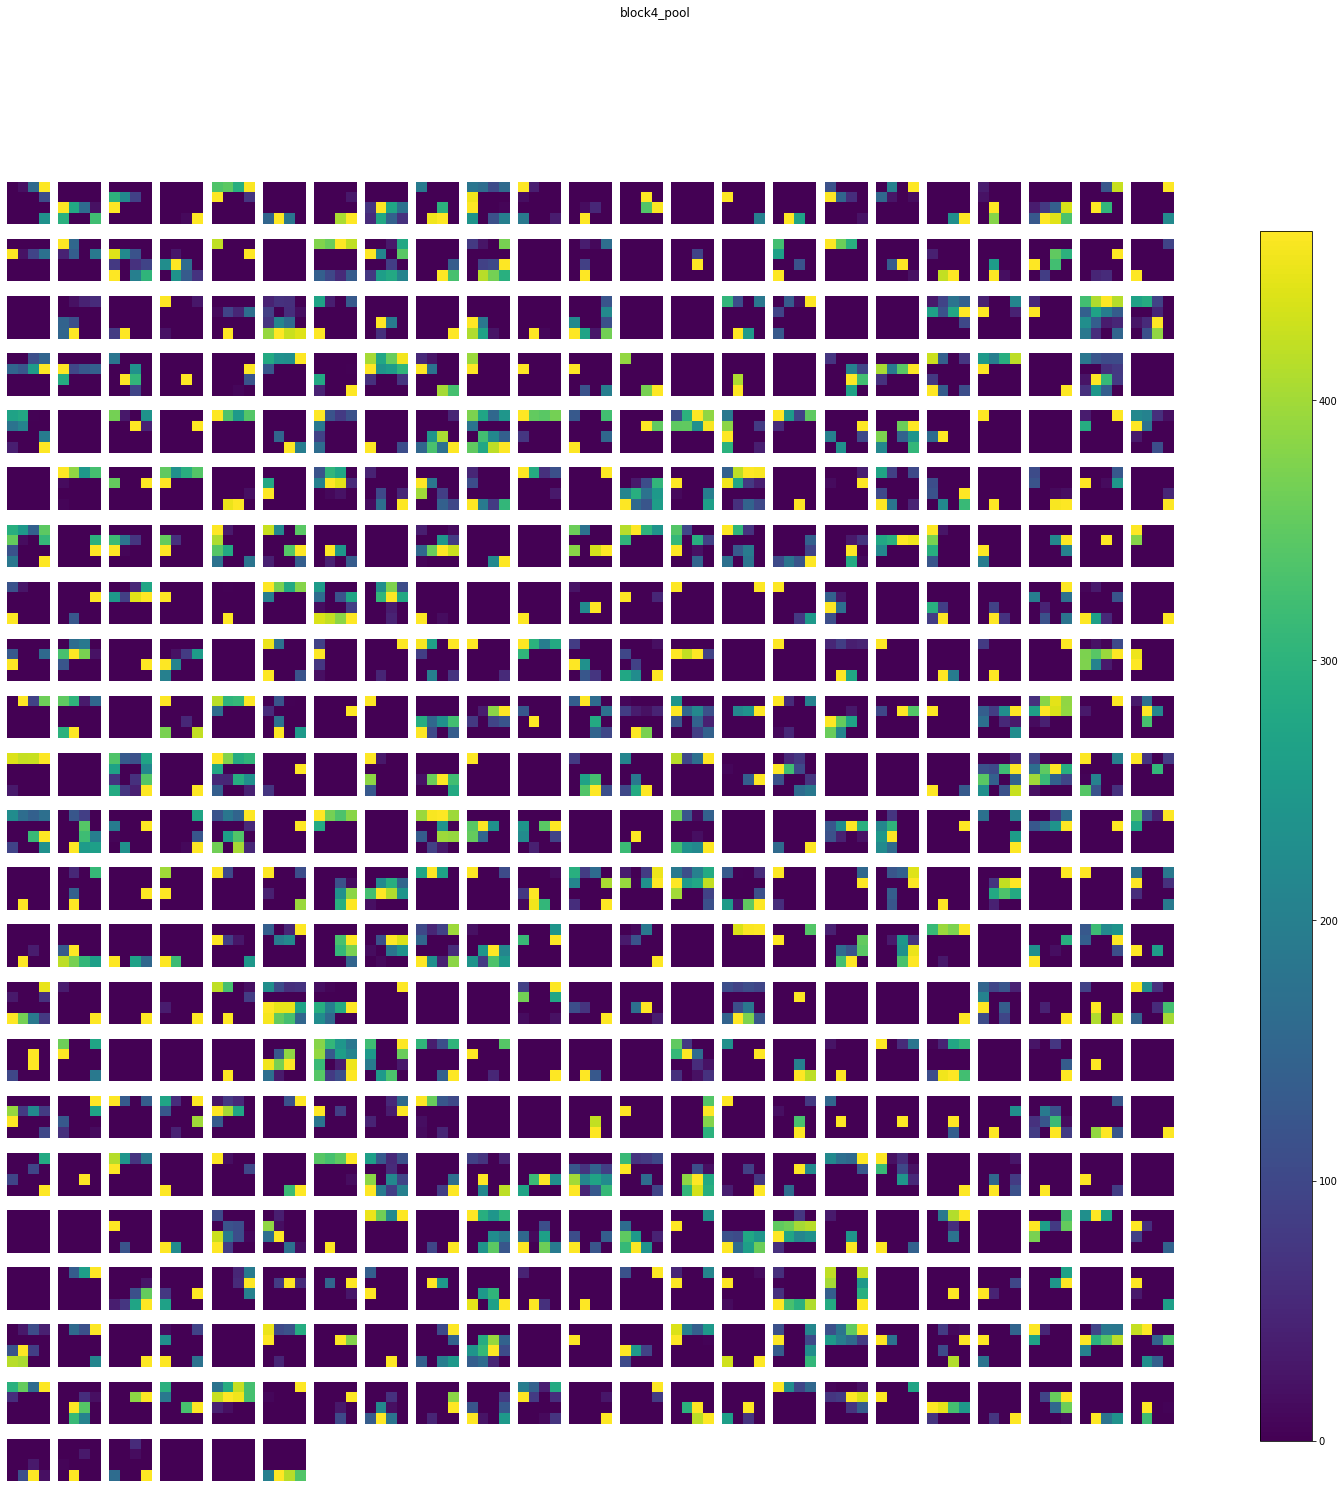

block5_conv1 (1, 4, 4, 512) 


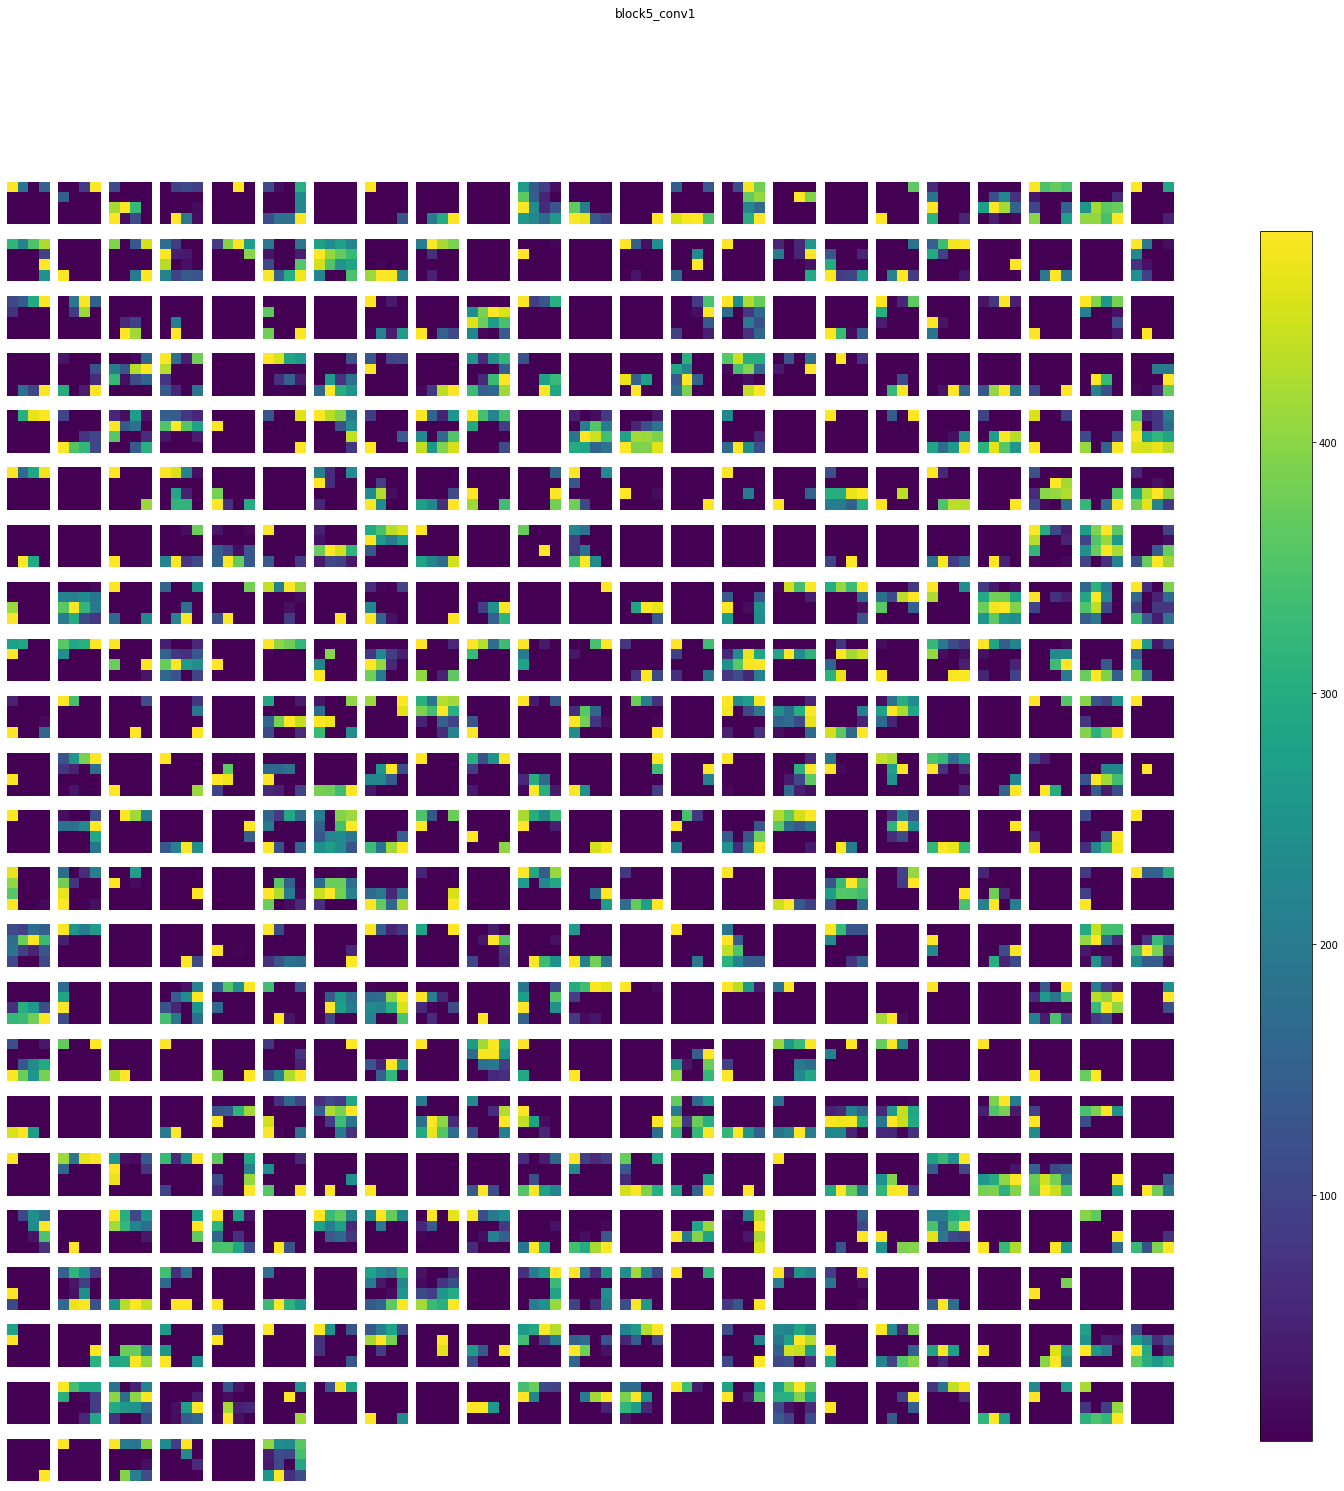

block5_conv2 (1, 4, 4, 512) 


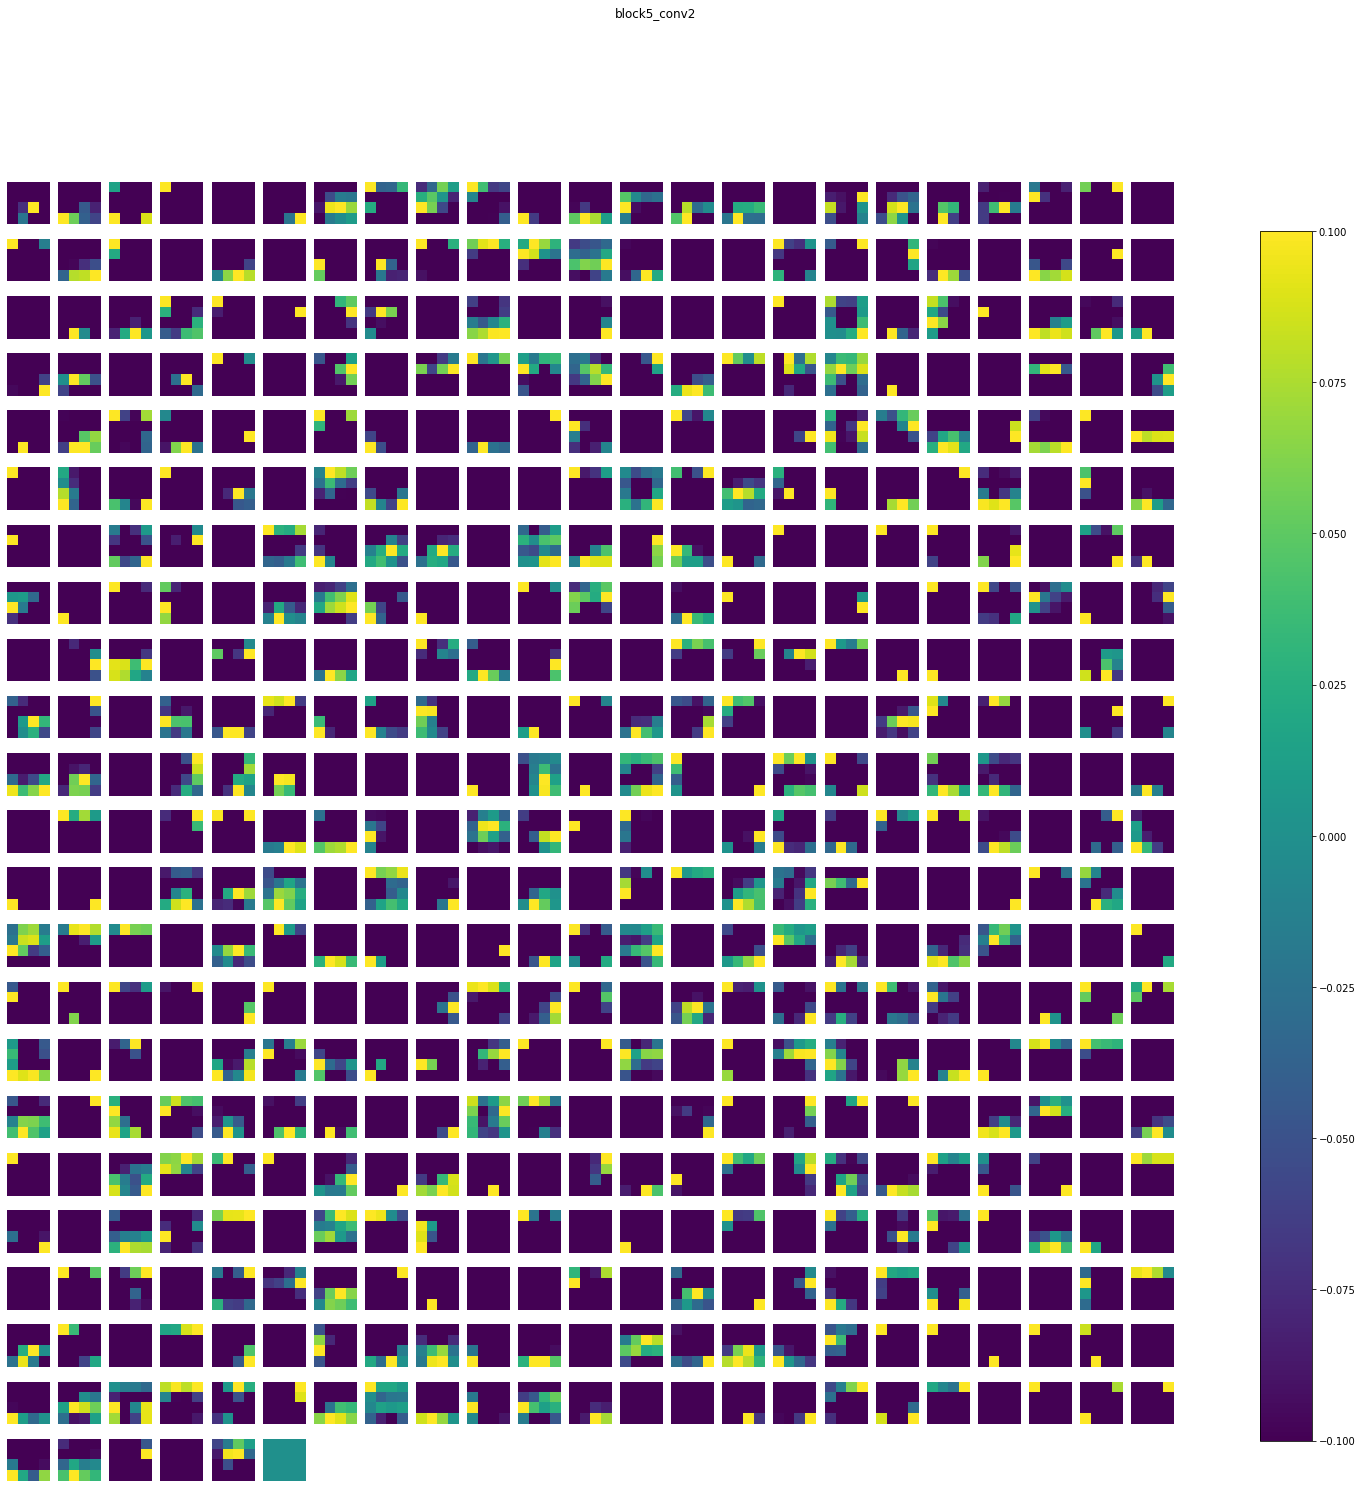

block5_conv3 (1, 4, 4, 512) 


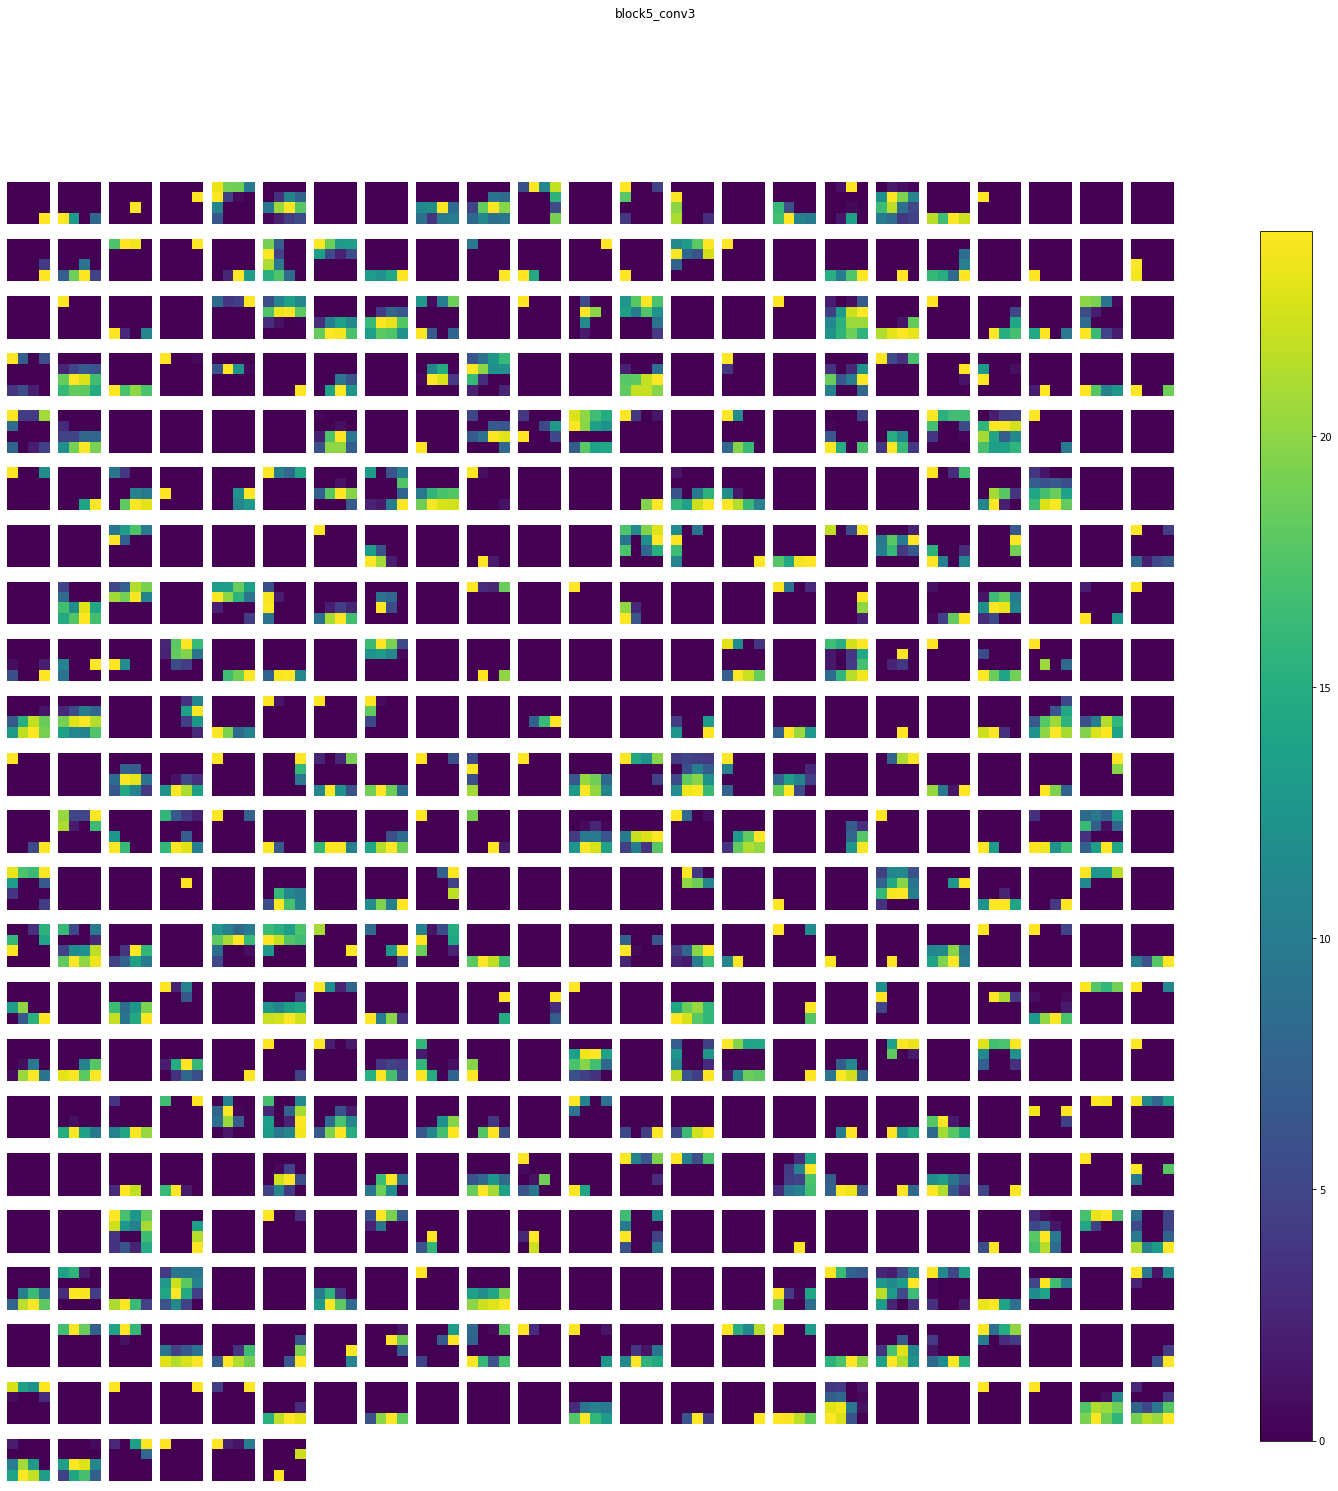

block5_conv4 (1, 4, 4, 512) 


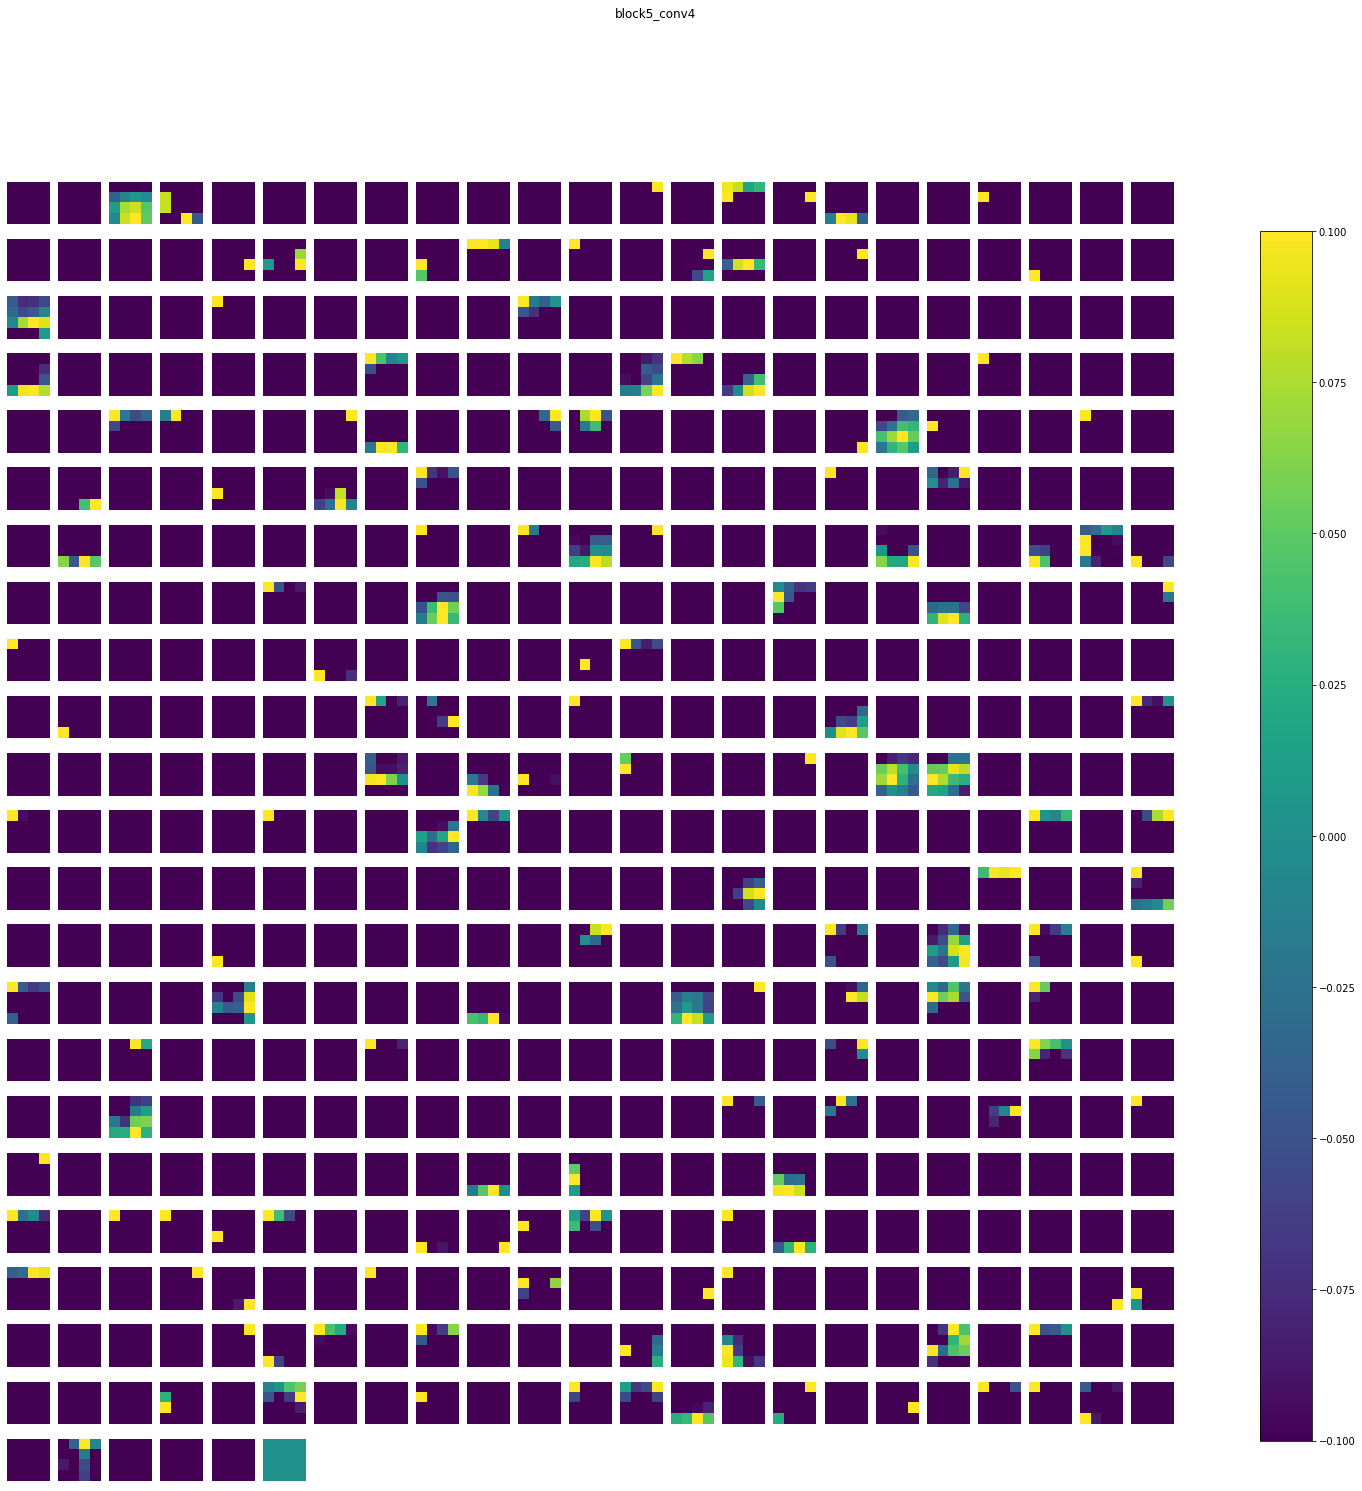

block5_pool (1, 2, 2, 512) 


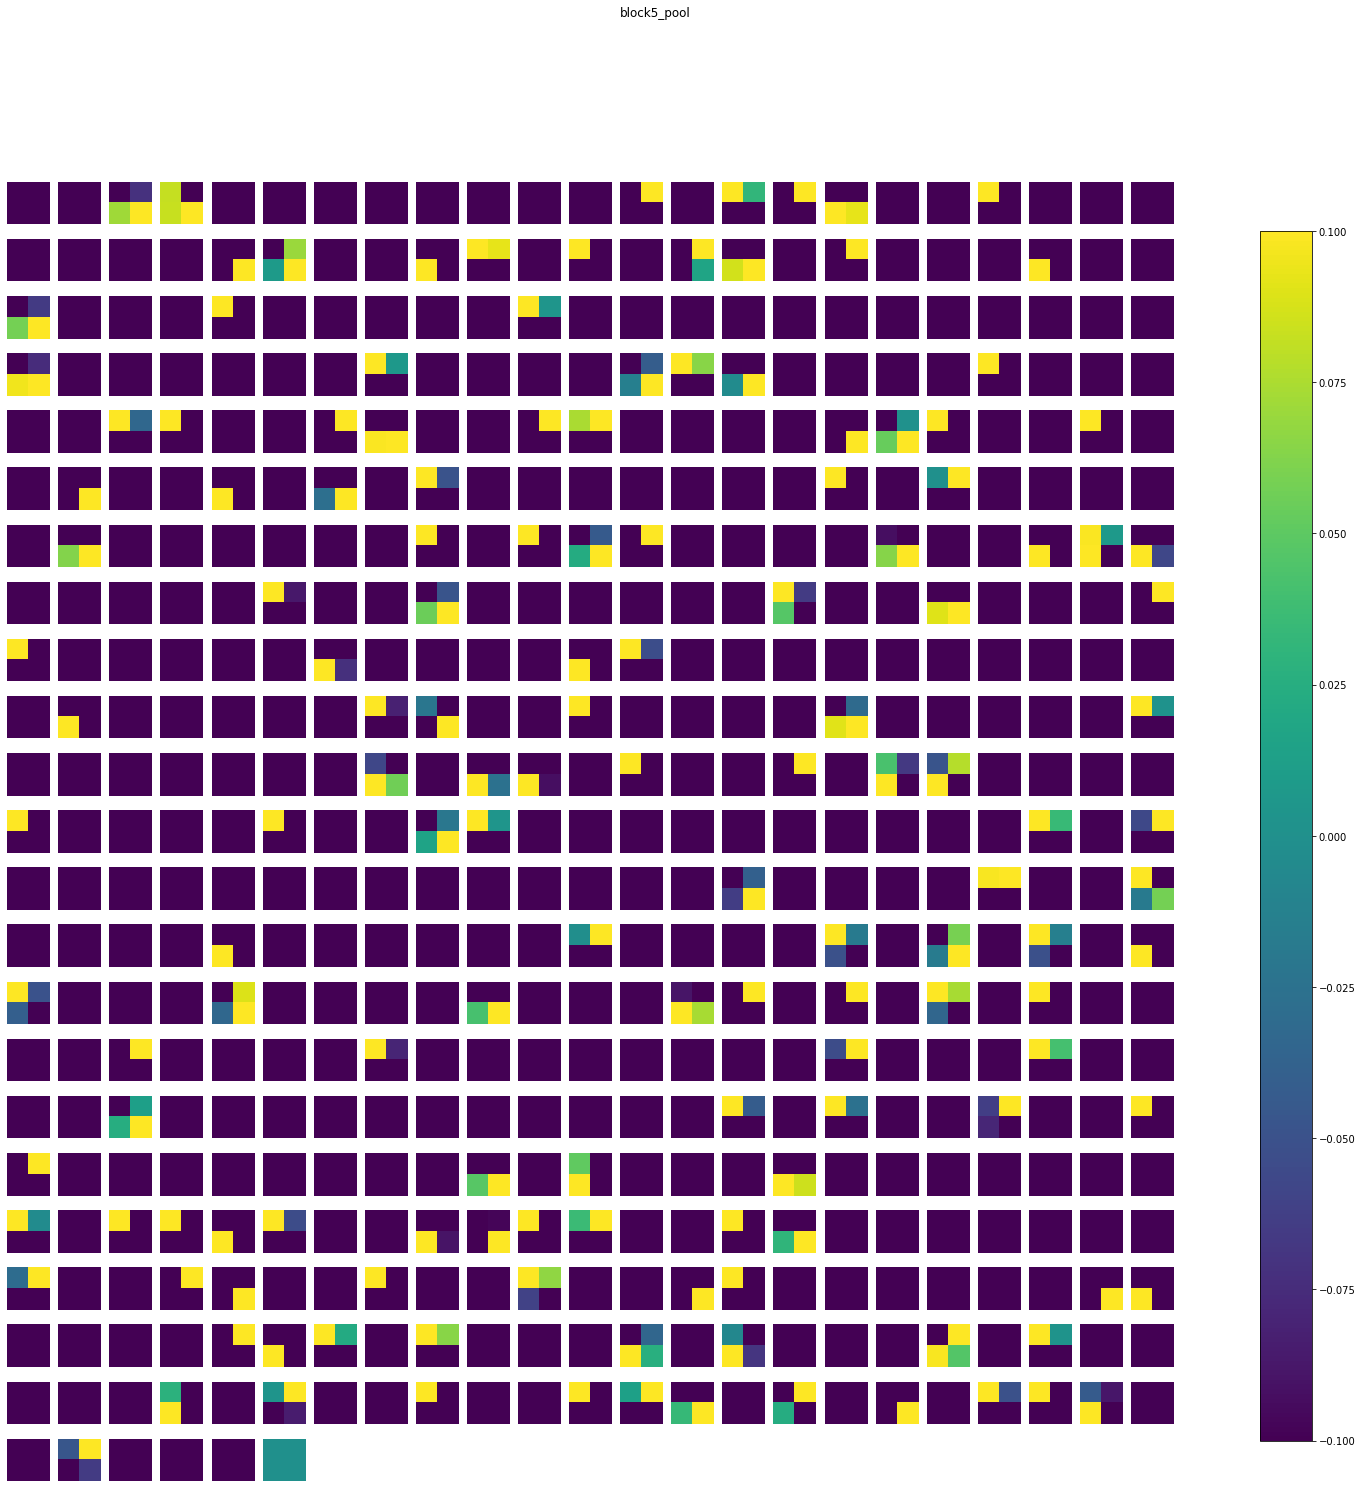

flatten_1 (1, 2048) 


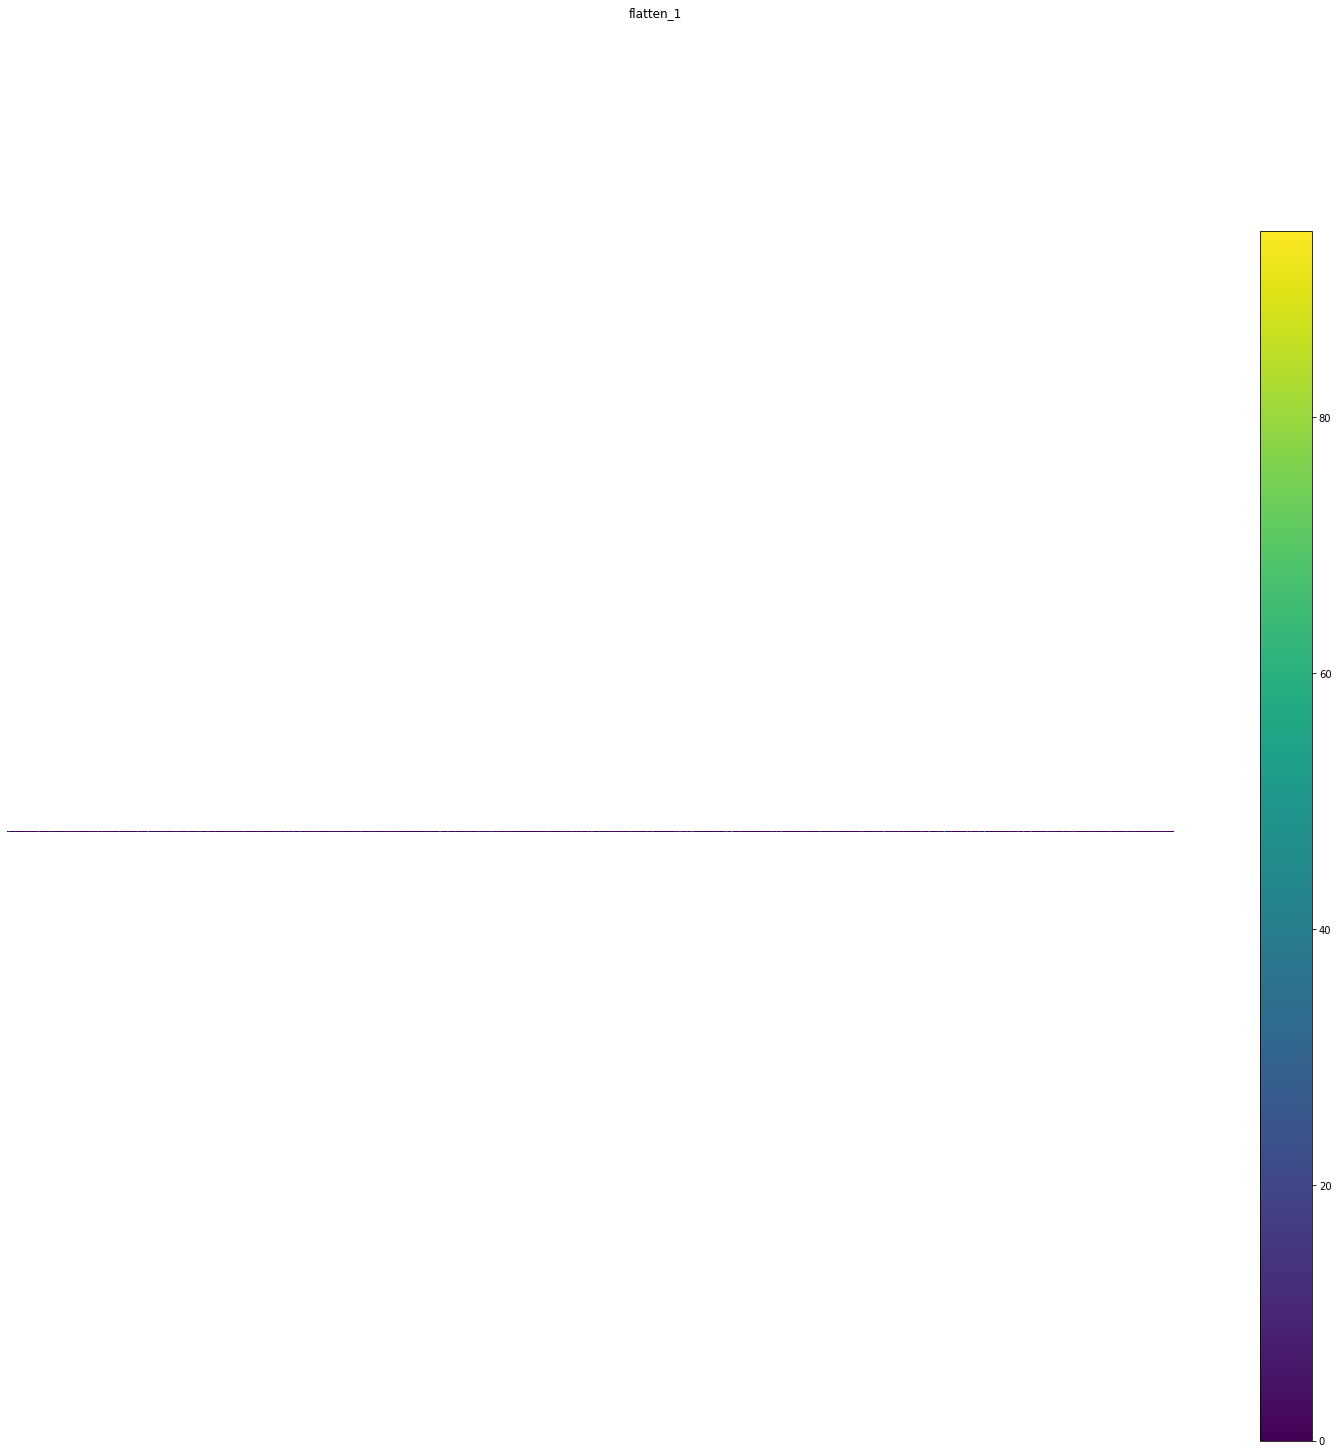

dense_2 (1, 128) 


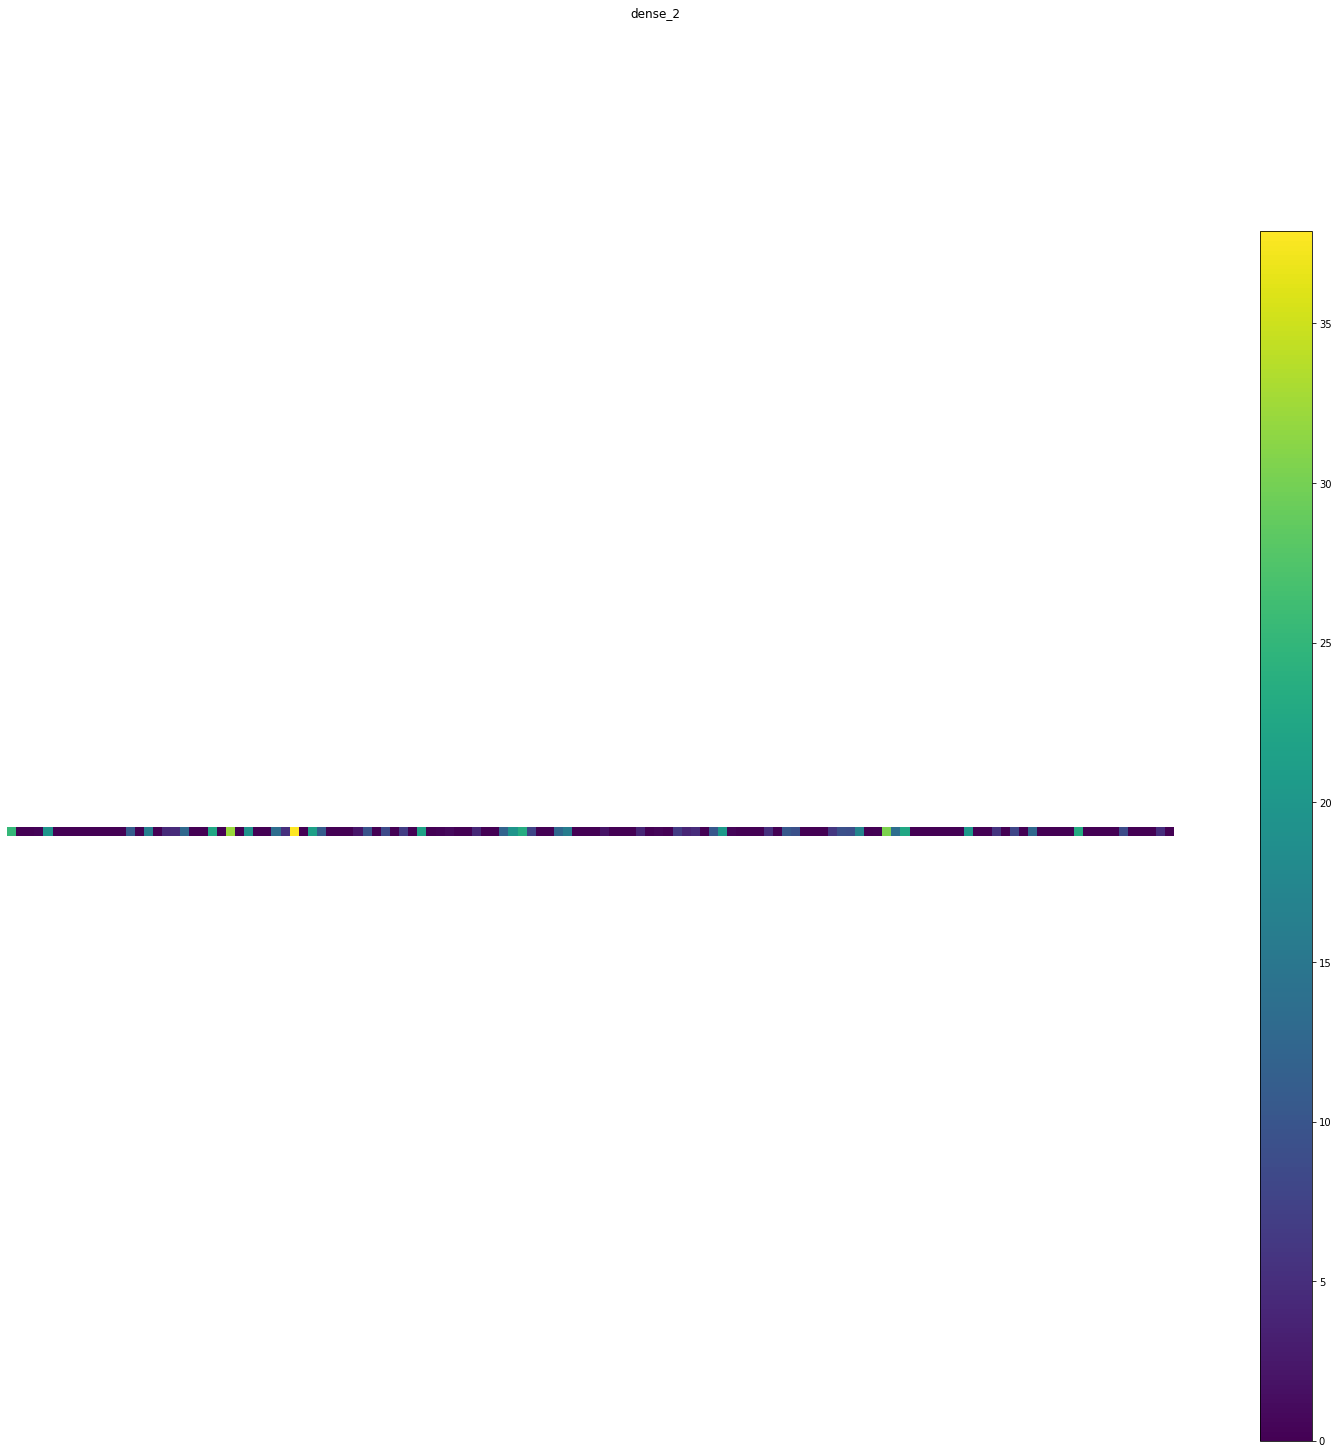

dense_3 (1, 128) 


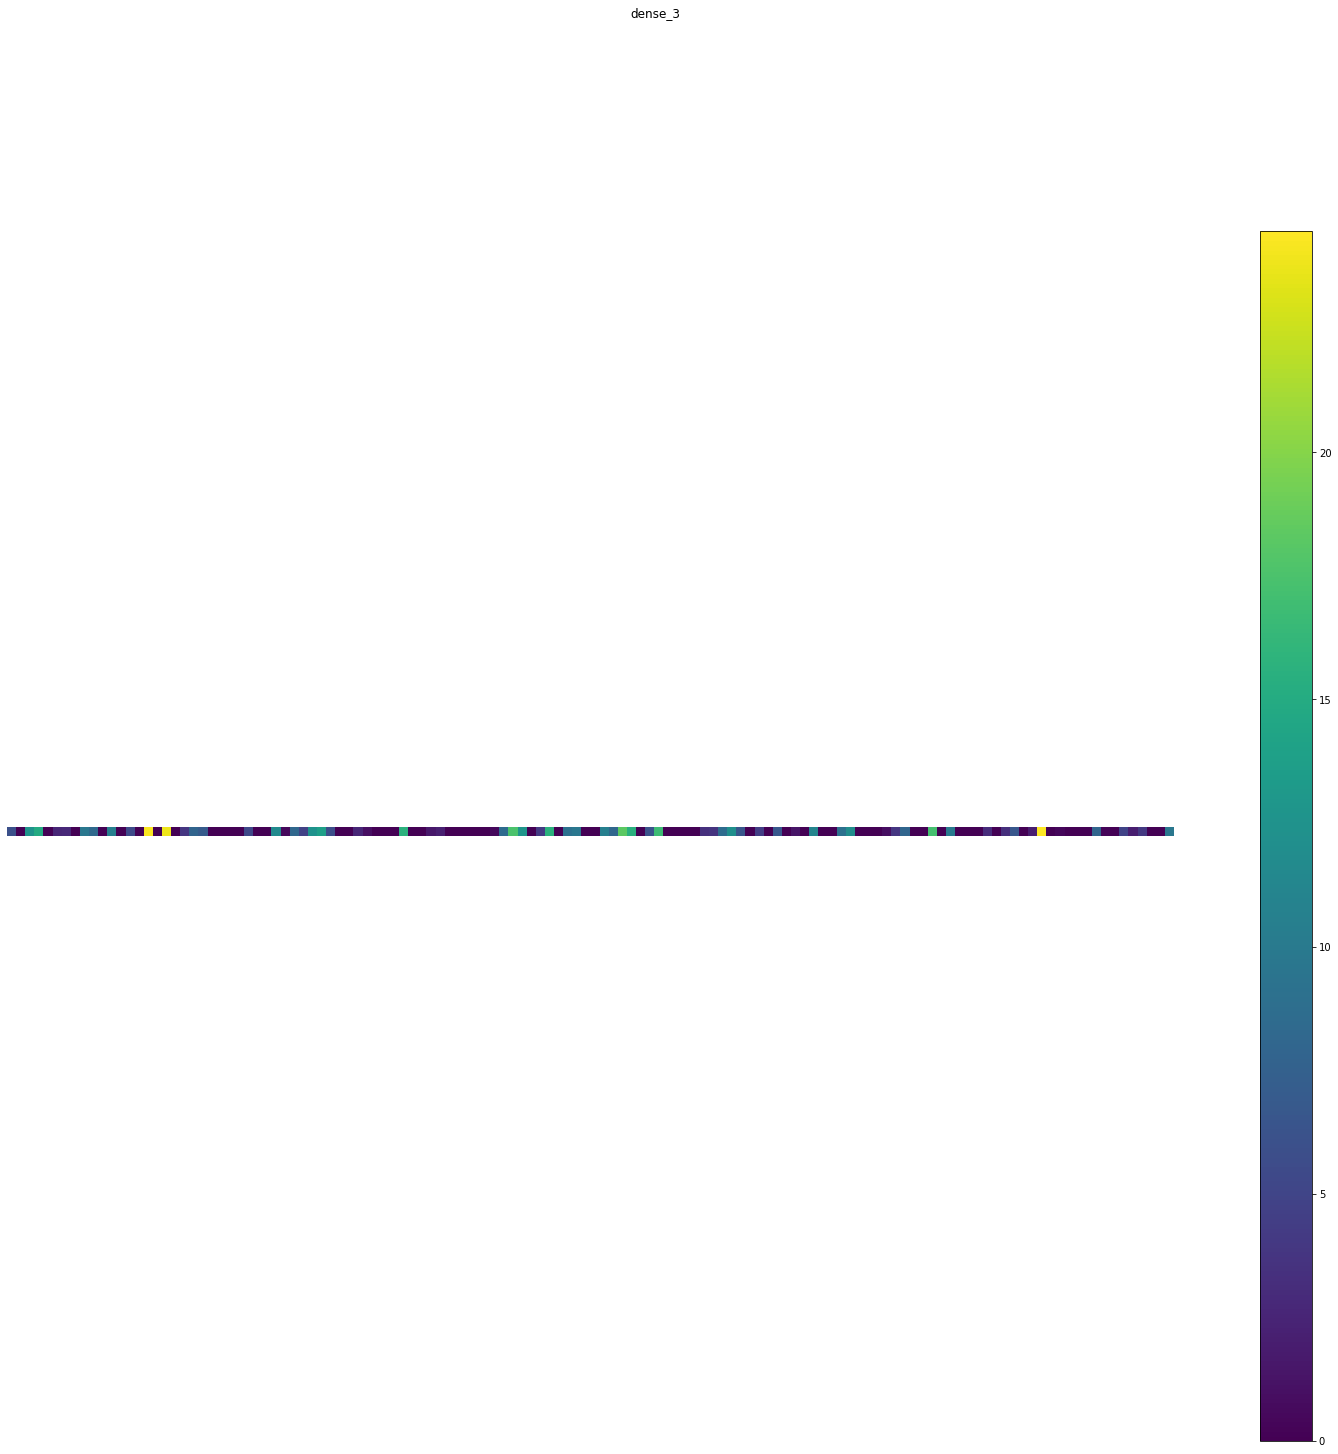

dense_4 (1, 2) 


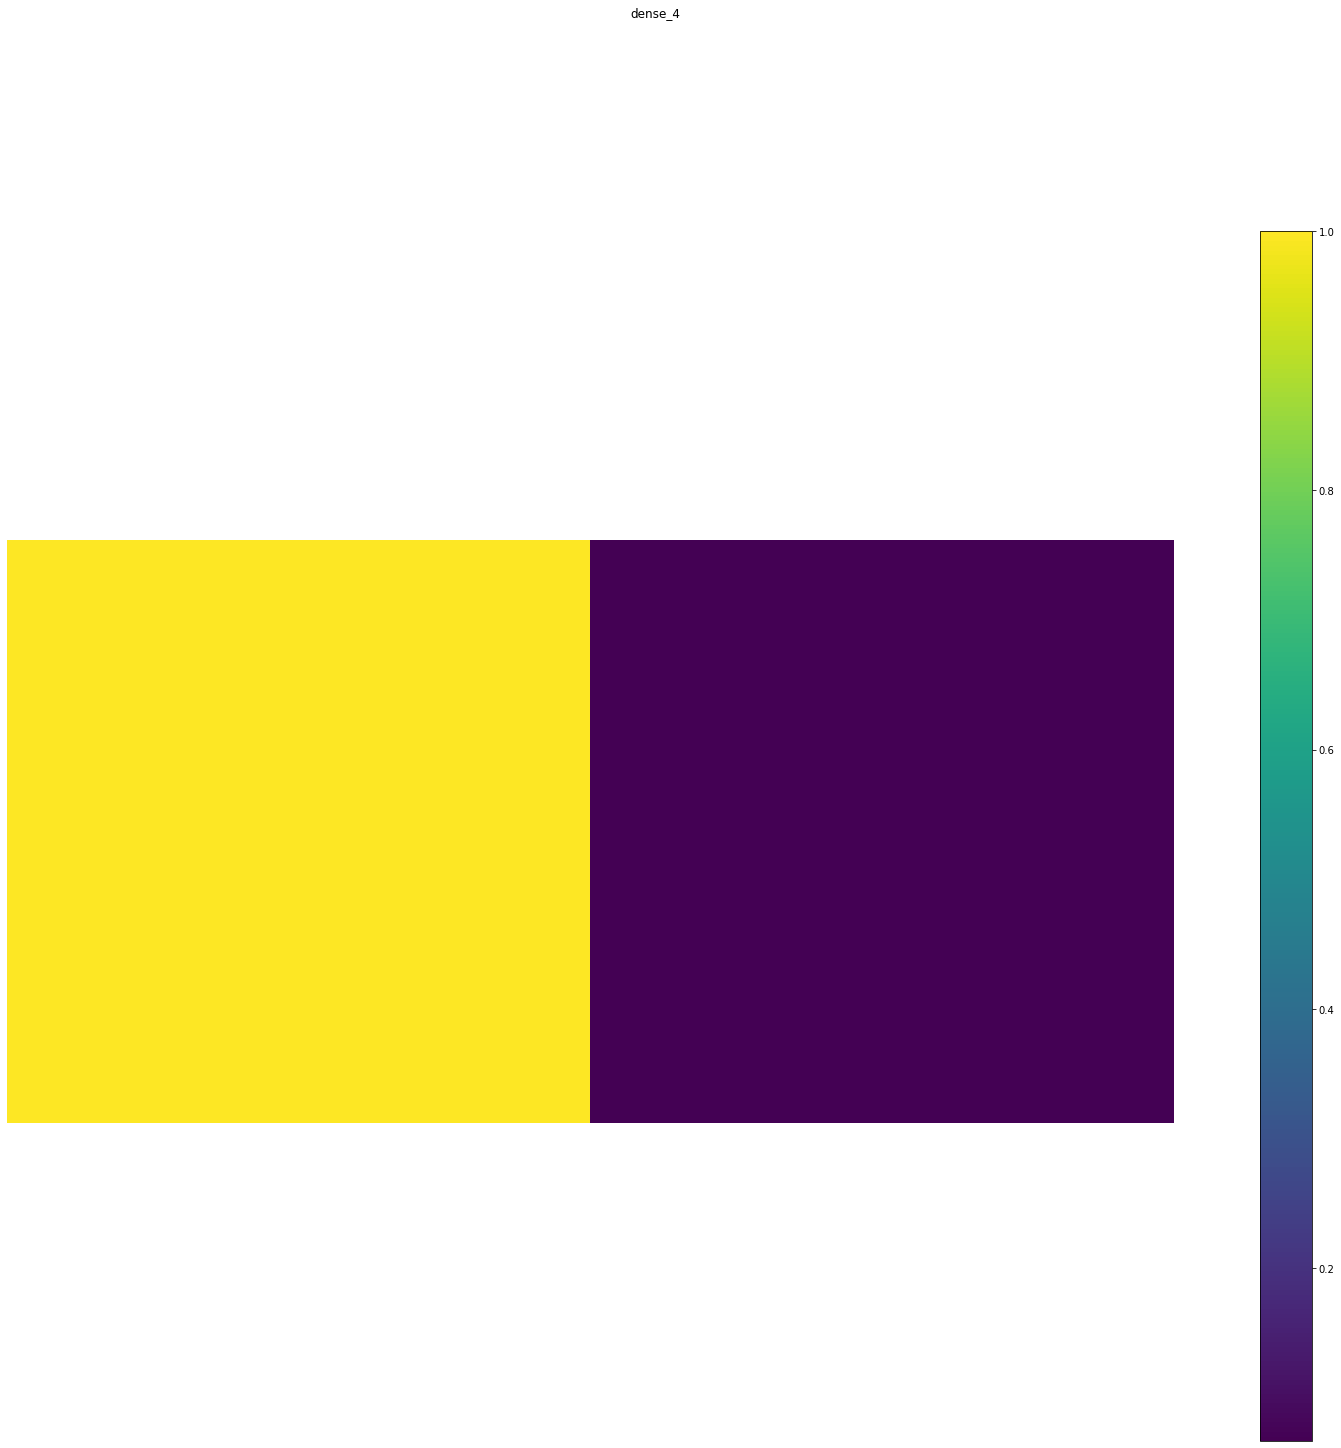

In [ ]:
display_activations(activations)

In [ ]:
!pip install scikit-learn==0.23.2

     |████████████████████████████████| 6.8 MB 5.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


input_2 (1, 64, 64, 3) 


ValueError: ignored

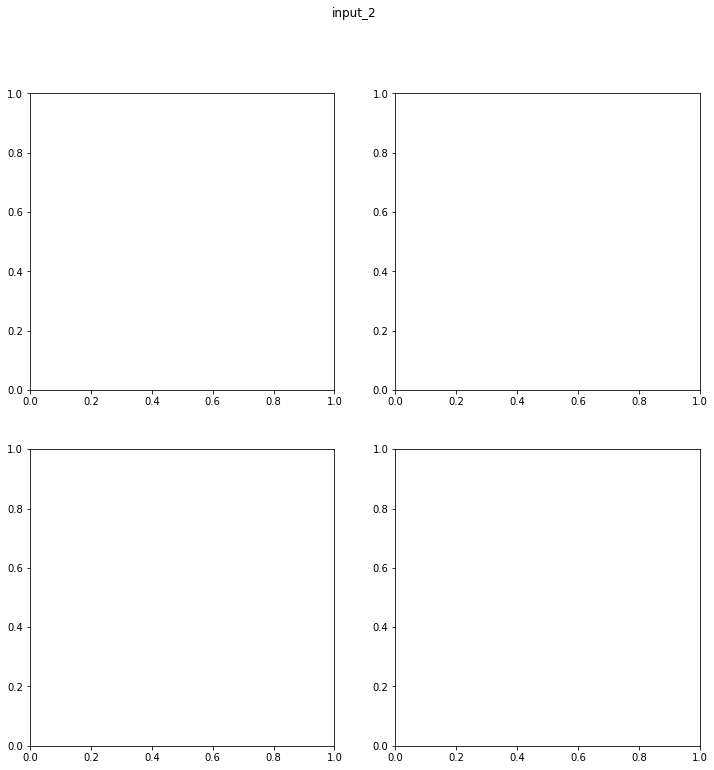

In [ ]:
display_heatmaps(activations, test_img)